# ML Project by Aun Muhammad Ashraf and Anas Semsayan (15-288)

## D2 Submission : Data Ingestion & Processing Pipeline - Data Acquisition, Analysis, Wrangling, Feature Engineering

# Table of Contents

- [D2.1 Simulating a Synthetic Dataset](#d21-simulating-a-synthetic-dataset)  
  - [Why simulate data?](#why-simulate-data)  
  - [What we simulate](#what-we-simulate)  
  - [Injecting realism](#injecting-realism)  
- [Corrupting of Data](#corrupting-of-data)  
- [D2.2 Exploratory Data Analysis](#d22-exploratory-data-analysis)  
- [D2.3 Data Wrangling](#d23-data-wrangling)  
- [D2.4 Feature Engineering](#d24-feature-engineering)  
  - [1. Feature Importance: Correlation with Target](#1-feature-importance-correlation-with-target)  
  - [2. Prune Redundant Features](#2-prune-redundant-features)  
  - [3. Feature Creation](#3-feature-creation)  
  - [4. Feature Scaling](#4-feature-scaling)  
- [Targeted Final Exploratory DATA ANALYSIS](#targeted-final-exploratory-data-analysis)
- [Final Summary](#targeted-final-exploratory-data-analysis)


# D2.1 Simulating a Synthetic Dataset

### Why simulate data?
Since we don’t have access to a real dataset, we simulate one that mimics the structure of university course difficulty evaluations. This allows us to control and inject patterns that mirror real-world behaviors.

 ### What we simulate
Course structure: assignments_per_week, hours_per_week, units, projects

Instructor and course quality: professor_rating, course_rating, sentiment_score, grading_strictness

Student performance proxies: student_percentage_estimate, drop_rate, failure_rate

Target: difficulty_level (Easy, Medium, Hard) is derived from a weighted scoring system

### Injecting realism
We:

Introduce missing values

Add outliers (e.g., 45 hours/week)

--------------------------------------

In this piece of code we are simulating a synthetic dataset of 50,000 university courses by generating realistic academic features such as professor rating, grading strictness, student performance, and engagement metrics using probabilistic sampling and rule-based calculations.

In [386]:
import pandas as pd
import numpy as np
import random

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

# Number of data points
num_samples = 50000

# Generate independent features first
prof_rating_choices = [1.0, 2.0, 3.0, 4.0, 5.0]
prof_rating_probs = [0.15, 0.20, 0.35, 0.25, 0.05]  #
# Random choice (weighted)
professor_rating = np.random.choice(prof_rating_choices, size=num_samples, p=prof_rating_probs)

grading_strictness = np.round(np.random.uniform(1.0, 5.0, num_samples), 1)
assignments_per_week = np.random.randint(0, 6, num_samples)
attendance_required = np.random.choice([0, 1], num_samples)
# course_level = np.random.choice(['Undergrad', 'Grad', 'Elective', 'Core'], num_samples)
projects = np.random.choice([0, 1], num_samples)
midterms_count = np.random.randint(0, 3, num_samples)
final_exam = np.random.choice([0, 1], num_samples)
subject_area = np.random.choice(['STEM', 'Humanities', 'Social Science'], num_samples)

# New features
unit_choices = [3, 3, 3, 6, 9, 9, 9, 9, 9, 12, 12]
units = np.random.choice(unit_choices, num_samples)

# Stronger link between units and hours (with variation to simulate 'easy' courses)

subject_penalty = [5 if s == 'STEM' else -3 if s == 'Humanities' else 0 for s in subject_area]
student_percentage_estimate = (
    90 - 5 * grading_strictness - np.array(subject_penalty) + np.random.normal(0, 5, num_samples)
)

student_percentage_estimate = np.clip(student_percentage_estimate, 50, 100)
student_percentage_estimate = np.round(student_percentage_estimate, 1)

# Failure rate derived from inverse of student performance with noise
failure_rate = np.clip((100 - student_percentage_estimate) / 100 + np.random.normal(0, 0.05, num_samples), 0, 0.4)
failure_rate = np.round(failure_rate, 2)

# Drop rate now related to failure rate with some noise
drop_rate = np.clip(failure_rate * 0.7 + np.random.normal(0, 0.03, num_samples), 0, 0.3)
drop_rate = np.round(drop_rate, 2)

hours_per_week = (
    0.5 * assignments_per_week * np.random.uniform(2.0, 3.0, num_samples) +
    0.7 * units +
    0.2 * (100 - student_percentage_estimate) * 0.1 +
    np.random.normal(0, 1.0, num_samples)
)
hours_per_week = np.clip(hours_per_week, 1, 20).astype(int)

# Course rating influenced by prof rating & grading strictness
course_rating = 1 * professor_rating - 0.2 * grading_strictness + np.random.normal(0, 0.5, num_samples)
course_rating = np.clip(course_rating, 1.0, 5.0)
course_rating = np.round(course_rating, 1)

# Sentiment score depends on course rating, prof rating, and drop rate
sentiment_score = (
    0.25 * (course_rating - 3) +
    0.25 * (professor_rating - 3) -
    0.5 * drop_rate +
    np.random.normal(0, 0.5, num_samples)
)
sentiment_score = np.clip(sentiment_score, -1.0, 1.0)
sentiment_score = np.round(sentiment_score, 2)


---------------------

In this section, we combine all the generated features into a single DataFrame and fill any missing values for professor_rating and sentiment_score. We then define a custom assign_difficulty function that calculates a raw difficulty score for each course based on various factors such as workload, grading strictness, student feedback, and subject area, with additional weight given to STEM courses. Using these scores, we label each course as "Easy", "Medium", or "Hard" to create a balanced difficulty distribution across the dataset. Finally, we shuffle the dataset to randomize the row order for fairness and realism.

In [390]:
# Combine into DataFrame
df = pd.DataFrame({
    'course_rating': course_rating,
    'assignments_per_week': assignments_per_week,
    'attendance_required': attendance_required,
    'professor_rating': np.round(professor_rating, 1),
    'sentiment_score': sentiment_score,
    # 'course_level': course_level,
    'subject_area': subject_area,
    'units': units,
    'hours_per_week': hours_per_week,
    'projects': projects,
    'midterms_count': midterms_count,
    'final_exam': final_exam,
    'grading_strictness': grading_strictness,
    'student_percentage_estimate': student_percentage_estimate,
    'drop_rate': drop_rate,
    'failure_rate': failure_rate
})

# Fill missing values for rating/sentiment simulation (temporarily)
df['professor_rating'].fillna(df['professor_rating'].mean(), inplace=True)
df['sentiment_score'].fillna(df['sentiment_score'].mean(), inplace=True)

# Difficulty scoring function with subject/failure/drop rate influence
def assign_difficulty(row):
    score = 0
    feedback_weight = (row['student_percentage_estimate'] - 50) / 50  # 0 to 1
    feedback_weight = np.clip(feedback_weight, 0, 1)

    # Apply subject-based weight multiplier (more weight in STEM)
    weight_multiplier = 1.3 if row['subject_area'] == 'STEM' else 1.0

    score += weight_multiplier * (row['assignments_per_week'] * 1.5)
    score += weight_multiplier * (row['attendance_required'] * 1.0)
    score -= weight_multiplier * (row['course_rating'] * 2 * feedback_weight)
    score -= weight_multiplier * (row['professor_rating'] * 1.2 * feedback_weight)
    score -= weight_multiplier * (row['sentiment_score'] * 5 * feedback_weight)
    score += weight_multiplier * (row['grading_strictness'] * 1.0)
    score += weight_multiplier * (row['hours_per_week'] * 0.3)
    score += weight_multiplier * (row['midterms_count'] * 1.2)
    score += weight_multiplier * (row['final_exam'] * 1.0)
    score += weight_multiplier * (row['projects'] * 0.8)
    score += weight_multiplier * ((100 - row['student_percentage_estimate']) * 0.05)
    score += weight_multiplier * ((row['units'] - row['hours_per_week']) * -0.3)
    score += weight_multiplier * (row['drop_rate'] * 10)
    score += weight_multiplier * (row['failure_rate'] * 8)
    score += np.random.normal(0, 1)

    return score

# Assign raw difficulty score for balancing
df['difficulty_score'] = df.apply(assign_difficulty, axis=1)

# Sort by score and assign labels to balance distribution (approx. 40-30-30)
df = df.sort_values(by='difficulty_score').reset_index(drop=True)
df.loc[:num_samples*0.3, 'difficulty_level'] = 'Easy'
df.loc[num_samples*0.3:num_samples*0.65, 'difficulty_level'] = 'Medium'
df.loc[num_samples*0.65:, 'difficulty_level'] = 'Hard'

# Final shuffle
df = df.sample(frac=1).reset_index(drop=True)

C:\Users\Aun Ashraf\AppData\Local\Temp\ipykernel_25220\695919783.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['professor_rating'].fillna(df['professor_rating'].mean(), inplace=True)
C:\Users\Aun Ashraf\AppData\Local\Temp\ipykernel_25220\695919783.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting value

This section defines 10 manually crafted anomaly cases with unusual feature combinations. Each is scored for difficulty, labeled as Easy, Medium, or Hard, and then added to the main dataset to enhance diversity and realism.

In [392]:
# Define 10 diverse anomaly rows
anomalies = pd.DataFrame([
    # 1. Zero assignments, high hours
    {'course_rating': 3.0, 'assignments_per_week': 0, 'attendance_required': 1,
     'professor_rating': 4.0, 'sentiment_score': 0.2, 'subject_area': 'STEM',
     'units': 6, 'hours_per_week': 20, 'projects': 1, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 3.0, 'student_percentage_estimate': 80, 'drop_rate': 0.05, 'failure_rate': 0.1},

    # 2. High GPA, high failure
    {'course_rating': 4.5, 'assignments_per_week': 3, 'attendance_required': 1,
     'professor_rating': 4.5, 'sentiment_score': 0.8, 'subject_area': 'STEM',
     'units': 9, 'hours_per_week': 12, 'projects': 1, 'midterms_count': 2, 'final_exam': 1,
     'grading_strictness': 4.0, 'student_percentage_estimate': 95, 'drop_rate': 0.05, 'failure_rate': 0.4},

    # 3. Humanities with extreme grading
    {'course_rating': 2.0, 'assignments_per_week': 1, 'attendance_required': 0,
     'professor_rating': 3.0, 'sentiment_score': -0.3, 'subject_area': 'Humanities',
     'units': 3, 'hours_per_week': 5, 'projects': 0, 'midterms_count': 0, 'final_exam': 1,
     'grading_strictness': 5.0, 'student_percentage_estimate': 60, 'drop_rate': 0.1, 'failure_rate': 0.3},

    # 4. Low units, massive time
    {'course_rating': 3.0, 'assignments_per_week': 2, 'attendance_required': 1,
     'professor_rating': 3.5, 'sentiment_score': 0.0, 'subject_area': 'Social Science',
     'units': 3, 'hours_per_week': 20, 'projects': 1, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 3.0, 'student_percentage_estimate': 75, 'drop_rate': 0.1, 'failure_rate': 0.2},

    # 5. High sentiment, high dropout
    {'course_rating': 4.0, 'assignments_per_week': 2, 'attendance_required': 1,
     'professor_rating': 4.0, 'sentiment_score': 1.0, 'subject_area': 'STEM',
     'units': 9, 'hours_per_week': 10, 'projects': 1, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 2.5, 'student_percentage_estimate': 85, 'drop_rate': 0.3, 'failure_rate': 0.1},

    # 6. High prof rating, low course rating
    {'course_rating': 1.0, 'assignments_per_week': 1, 'attendance_required': 1,
     'professor_rating': 5.0, 'sentiment_score': -0.5, 'subject_area': 'STEM',
     'units': 6, 'hours_per_week': 8, 'projects': 0, 'midterms_count': 1, 'final_exam': 1,
     'grading_strictness': 4.0, 'student_percentage_estimate': 70, 'drop_rate': 0.2, 'failure_rate': 0.2},

    # 7. Final exam + midterms + no hours
    {'course_rating': 3.5, 'assignments_per_week': 2, 'attendance_required': 1,
     'professor_rating': 3.5, 'sentiment_score': 0.0, 'subject_area': 'Social Science',
     'units': 6, 'hours_per_week': 0, 'projects': 1, 'midterms_count': 2, 'final_exam': 1,
     'grading_strictness': 3.0, 'student_percentage_estimate': 65, 'drop_rate': 0.1, 'failure_rate': 0.25},

    # 8. Low feedback, labeled easy (add after label assignment manually if needed)
    {'course_rating': 2.0, 'assignments_per_week': 1, 'attendance_required': 0,
     'professor_rating': 2.0, 'sentiment_score': -0.7, 'subject_area': 'Humanities',
     'units': 3, 'hours_per_week': 4, 'projects': 0, 'midterms_count': 0, 'final_exam': 0,
     'grading_strictness': 1.0, 'student_percentage_estimate': 52, 'drop_rate': 0.05, 'failure_rate': 0.1},

    # 9. Conflicting feedback
    {'course_rating': 5.0, 'assignments_per_week': 3, 'attendance_required': 1,
     'professor_rating': 5.0, 'sentiment_score': -1.0, 'subject_area': 'STEM',
     'units': 12, 'hours_per_week': 15, 'projects': 1, 'midterms_count': 2, 'final_exam': 1,
     'grading_strictness': 3.5, 'student_percentage_estimate': 90, 'drop_rate': 0.05, 'failure_rate': 0.05},

    # 10. Everything zero (extreme edge case)
    {'course_rating': 1.0, 'assignments_per_week': 0, 'attendance_required': 0,
     'professor_rating': 1.0, 'sentiment_score': -1.0, 'subject_area': 'Humanities',
     'units': 3, 'hours_per_week': 0, 'projects': 0, 'midterms_count': 0, 'final_exam': 0,
     'grading_strictness': 1.0, 'student_percentage_estimate': 50, 'drop_rate': 0.0, 'failure_rate': 0.0},
])

# # Optional: Mark anomalies
# anomalies['is_anomaly'] = 1
# df['is_anomaly'] = 0

# Assign raw difficulty score for balancing
anomalies['difficulty_score'] = anomalies.apply(assign_difficulty, axis=1)

num_anomalies = len(anomalies)

# Sort by score and assign labels to balance distribution (approx. 40-30-30)
anomalies = anomalies.sort_values(by='difficulty_score').reset_index(drop=True)
anomalies.loc[:num_anomalies*0.3, 'difficulty_level'] = 'Easy'
anomalies.loc[num_anomalies*0.3:num_anomalies*0.65, 'difficulty_level'] = 'Medium'
anomalies.loc[num_anomalies*0.65:, 'difficulty_level'] = 'Hard'

# Append to df
df = pd.concat([df, anomalies], ignore_index=True)

Here, we save the final dataset as a CSV file and display the first few rows to confirm successful generation and structure.

In [394]:
df.to_csv('course_difficulty_dataset.csv', index=False)

print("Balanced and enriched dataset generated as 'course_difficulty_dataset.csv'!")
df.head()

Balanced and enriched dataset generated as 'course_difficulty_dataset.csv'!


course_rating  assignments_per_week  attendance_required  professor_rating  \
0            2.8                     1                    1               4.0   
1            3.1                     0                    1               3.0   
2            3.9                     2                    0               4.0   
3            1.8                     5                    0               2.0   
4            3.3                     3                    0               4.0   

   sentiment_score    subject_area  units  hours_per_week  projects  \
0             0.18      Humanities     12               9         1   
1             0.40            STEM      3               2         0   
2             0.59      Humanities      3               5         1   
3            -0.57      Humanities      9              13         1   
4             1.00  Social Science      9              11         0   

   midterms_count  final_exam  grading_strictness  \
0               0           0                 1.0   
1               1           0                 3.3   
2               2           1                 2.4   
3               1           1                 1.0   
4               0           0                 4.0   

   student_percentage_estimate  drop_rate  failure_rate  difficulty_score  \
0                         89.9       0.10          0.08         -2.252490   
1                         65.5       0.28          0.34         13.940905   
2                         73.8       0.16          0.28         10.155458   
3                         91.2       0.00          0.00         15.505456   
4                         64.7       0.24          0.40         15.787459   

  difficulty_level  
0             Easy  
1           Medium  
2             Easy  
3           Medium  
4           Medium

We are computing the correlation matrix for all numeric features in the dataset to understand how they relate to each other. We are then visualizing these relationships using a heatmap, which helps us identify strong correlations, patterns, and potential multicollinearity between variables.

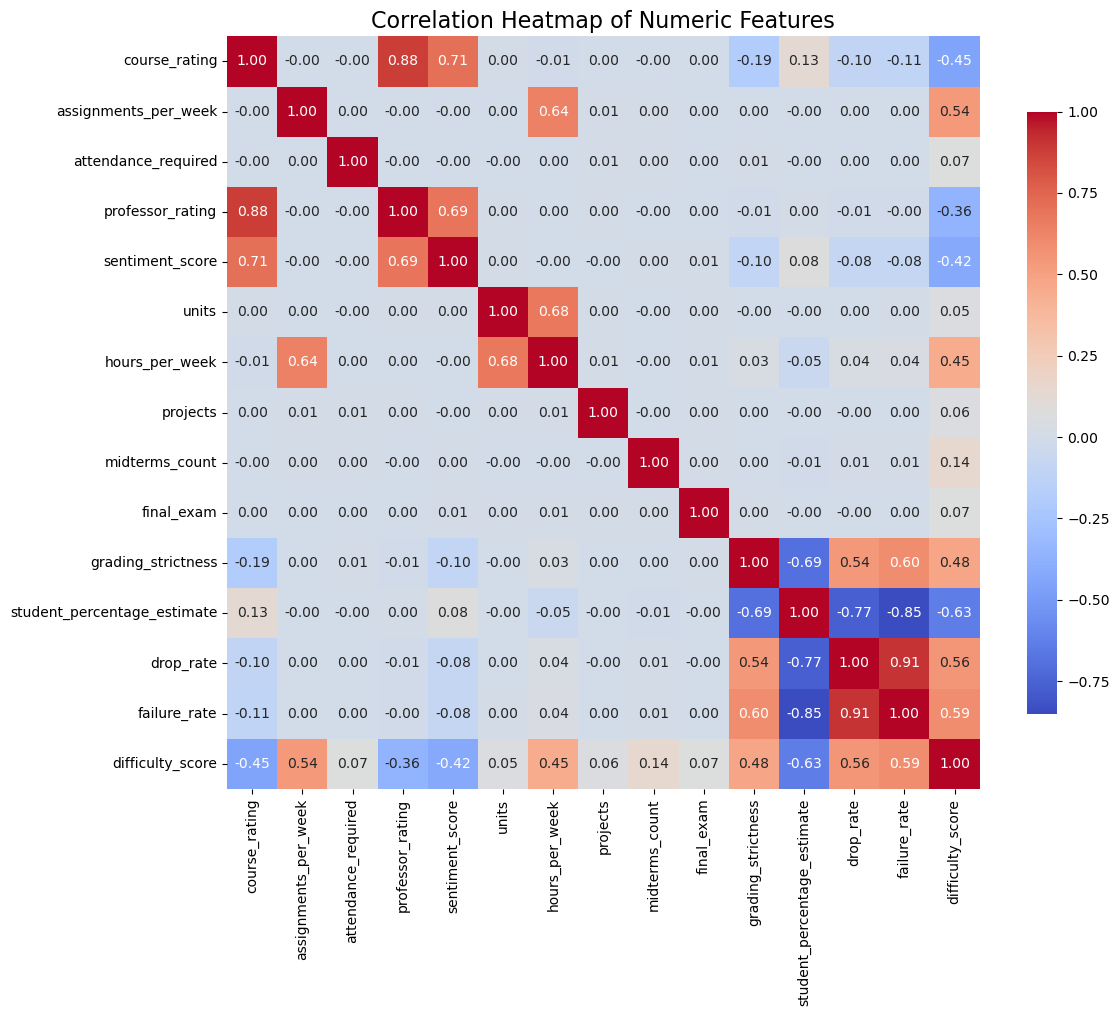

In [396]:
import seaborn as sns
import matplotlib.pyplot as plt
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

We are using boxplots to visualize how key features like grading strictness, hours per week, student performance, and difficulty score vary across different subject areas. This helps us compare the distributions and spot trends or differences between STEM, Humanities, and Social Science courses.

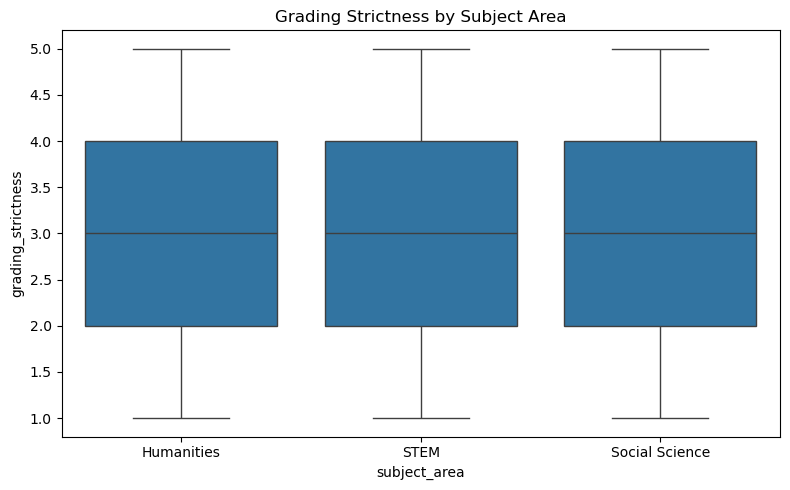

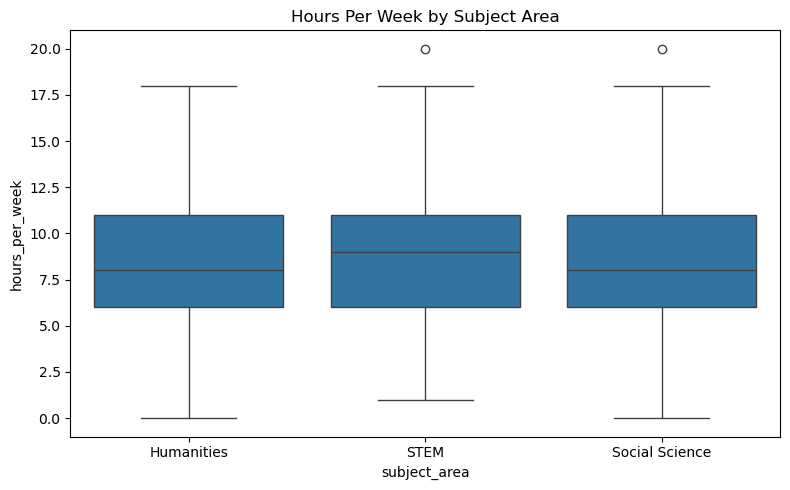

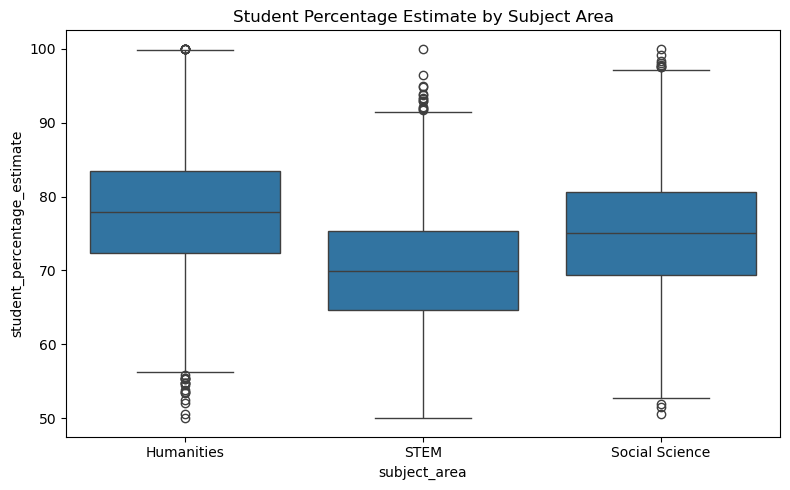

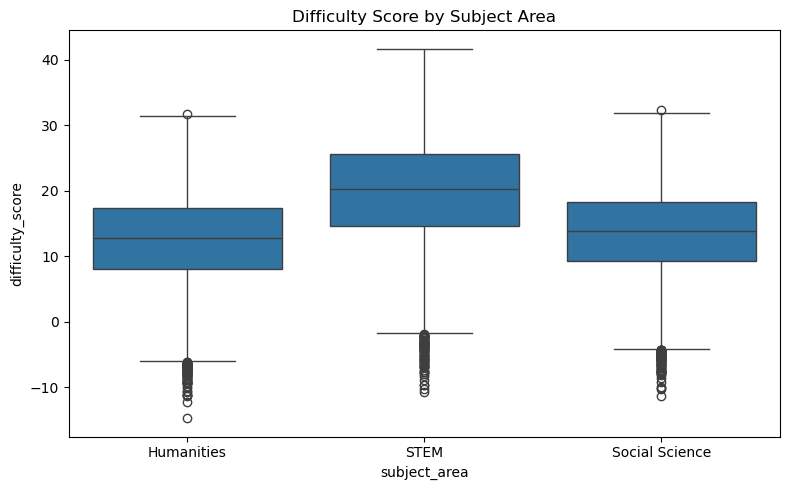

In [398]:
features = ['grading_strictness', 'hours_per_week', 'student_percentage_estimate', 'difficulty_score']
for feature in features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x='subject_area', y=feature, data=df)
    plt.title(f"{feature.replace('_', ' ').title()} by Subject Area")
    plt.tight_layout()
    plt.show()


## Corrupting of Data

We are simulating real-world data imperfections by randomly introducing missing values in 1% of the rows for each selected column. This allows us to prepare the dataset for data wrangling and cleaning tasks commonly encountered in practical data science workflows.

In [402]:
# Load the clean dataset
corrupted_df = pd.read_csv("course_difficulty_dataset.csv")

# Make the data "dirty" for wrangling tasks

# 1. Introduce missing values randomly (10% of values in selected columns)
cols_with_missing = df.columns.tolist()
cols_with_missing.remove("difficulty_score")
cols_with_missing.remove("difficulty_level")
for col in cols_with_missing:
    corrupted_df.loc[corrupted_df.sample(frac=0.01).index, col] = np.nan

We are introducing additional extreme outliers (in addition to the ones we added manually above) to simulate corrupted or unrealistic entries in the dataset. This includes inflating values like hours per week, student percentage estimates, course ratings, professor ratings, and grading strictness well beyond their normal ranges. These outliers help test the robustness of future cleaning and preprocessing steps.

In [405]:
# 2. Introduce extreme outliers artificially in addition to the ones we added above
corrupted_df.loc[corrupted_df.sample(frac=0.001).index, 'hours_per_week'] *= 3  # unrealistic time requirement
corrupted_df.loc[corrupted_df.sample(frac=0.001).index, 'student_percentage_estimate'] *= 1.5  # impossible percentage
corrupted_df.loc[corrupted_df.sample(frac=0.001).index, 'professor_rating'] *= 2
corrupted_df.loc[corrupted_df.sample(frac=0.001).index, 'grading_strictness'] *= 3
corrupted_df

course_rating  assignments_per_week  attendance_required  \
0                2.8                   1.0                  1.0   
1                3.1                   0.0                  1.0   
2                3.9                   2.0                  0.0   
3                1.8                   5.0                  0.0   
4                3.3                   3.0                  0.0   
...              ...                   ...                  ...   
50005            5.0                   3.0                  1.0   
50006            2.0                   1.0                  0.0   
50007            3.0                   0.0                  1.0   
50008            1.0                   1.0                  1.0   
50009            3.0                   2.0                  1.0   

       professor_rating  sentiment_score    subject_area  units  \
0                   4.0             0.18      Humanities   12.0   
1                   3.0             0.40            STEM    3.0   
2                   4.0             0.59      Humanities    3.0   
3                   2.0            -0.57      Humanities    9.0   
4                   4.0             1.00  Social Science    9.0   
...                 ...              ...             ...    ...   
50005               5.0            -1.00            STEM   12.0   
50006               3.0            -0.30      Humanities    3.0   
50007               4.0             0.20            STEM    6.0   
50008               5.0            -0.50            STEM    6.0   
50009               3.5             0.00  Social Science    3.0   

       hours_per_week  projects  midterms_count  final_exam  \
0                 9.0       1.0             0.0         0.0   
1                 2.0       0.0             1.0         0.0   
2                 NaN       1.0             2.0         1.0   
3                13.0       1.0             1.0         1.0   
4                11.0       0.0             0.0         0.0   
...               ...       ...             ...         ...   
50005            15.0       1.0             2.0         1.0   
50006             5.0       0.0             0.0         1.0   
50007            20.0       1.0             1.0         1.0   
50008             8.0       0.0             1.0         1.0   
50009            20.0       1.0             1.0         1.0   

       grading_strictness  student_percentage_estimate  drop_rate  \
0                     1.0                         89.9       0.10   
1                     3.3                         65.5       0.28   
2                     2.4                         73.8       0.16   
3                     1.0                         91.2       0.00   
4                     4.0                         64.7       0.24   
...                   ...                          ...        ...   
50005                 3.5                         90.0       0.05   
50006                 5.0                         60.0       0.10   
50007                 3.0                         80.0       0.05   
50008                 4.0                         70.0       0.20   
50009                 3.0                         75.0       0.10   

       failure_rate  difficulty_score difficulty_level  
0              0.08         -2.252490             Easy  
1              0.34         13.940905           Medium  
2              0.28         10.155458             Easy  
3              0.00         15.505456           Medium  
4               NaN         15.787459           Medium  
...             ...               ...              ...  
50005          0.05         13.141790           Medium  
50006          0.30         13.213071           Medium  
50007          0.10         14.738283             Hard  
50008          0.20         17.734865             Hard  
50009          0.20         21.579648             Hard  

[50010 rows x 17 columns]

In [407]:
# Save this dirty version to a new CSV
corrupted_df.to_csv("dirty_course_difficulty_dataset.csv", index=False)

corrupted_df.head()
corrupted_df

course_rating  assignments_per_week  attendance_required  \
0                2.8                   1.0                  1.0   
1                3.1                   0.0                  1.0   
2                3.9                   2.0                  0.0   
3                1.8                   5.0                  0.0   
4                3.3                   3.0                  0.0   
...              ...                   ...                  ...   
50005            5.0                   3.0                  1.0   
50006            2.0                   1.0                  0.0   
50007            3.0                   0.0                  1.0   
50008            1.0                   1.0                  1.0   
50009            3.0                   2.0                  1.0   

       professor_rating  sentiment_score    subject_area  units  \
0                   4.0             0.18      Humanities   12.0   
1                   3.0             0.40            STEM    3.0   
2                   4.0             0.59      Humanities    3.0   
3                   2.0            -0.57      Humanities    9.0   
4                   4.0             1.00  Social Science    9.0   
...                 ...              ...             ...    ...   
50005               5.0            -1.00            STEM   12.0   
50006               3.0            -0.30      Humanities    3.0   
50007               4.0             0.20            STEM    6.0   
50008               5.0            -0.50            STEM    6.0   
50009               3.5             0.00  Social Science    3.0   

       hours_per_week  projects  midterms_count  final_exam  \
0                 9.0       1.0             0.0         0.0   
1                 2.0       0.0             1.0         0.0   
2                 NaN       1.0             2.0         1.0   
3                13.0       1.0             1.0         1.0   
4                11.0       0.0             0.0         0.0   
...               ...       ...             ...         ...   
50005            15.0       1.0             2.0         1.0   
50006             5.0       0.0             0.0         1.0   
50007            20.0       1.0             1.0         1.0   
50008             8.0       0.0             1.0         1.0   
50009            20.0       1.0             1.0         1.0   

       grading_strictness  student_percentage_estimate  drop_rate  \
0                     1.0                         89.9       0.10   
1                     3.3                         65.5       0.28   
2                     2.4                         73.8       0.16   
3                     1.0                         91.2       0.00   
4                     4.0                         64.7       0.24   
...                   ...                          ...        ...   
50005                 3.5                         90.0       0.05   
50006                 5.0                         60.0       0.10   
50007                 3.0                         80.0       0.05   
50008                 4.0                         70.0       0.20   
50009                 3.0                         75.0       0.10   

       failure_rate  difficulty_score difficulty_level  
0              0.08         -2.252490             Easy  
1              0.34         13.940905           Medium  
2              0.28         10.155458             Easy  
3              0.00         15.505456           Medium  
4               NaN         15.787459           Medium  
...             ...               ...              ...  
50005          0.05         13.141790           Medium  
50006          0.30         13.213071           Medium  
50007          0.10         14.738283             Hard  
50008          0.20         17.734865             Hard  
50009          0.20         21.579648             Hard  

[50010 rows x 17 columns]

In [408]:
corrupted_df.isnull().sum()

course_rating                  500
assignments_per_week           500
attendance_required            500
professor_rating               500
sentiment_score                500
subject_area                   500
units                          500
hours_per_week                 500
projects                       500
midterms_count                 500
final_exam                     500
grading_strictness             500
student_percentage_estimate    500
drop_rate                      500
failure_rate                   500
difficulty_score                 0
difficulty_level                 0
dtype: int64

# D2.2 Exploratory Data Analysis

We are loading the dirty dataset, correcting any datatype issues (especially in numeric columns), and displaying the dataset's features, correlations, outliers, and distributions to see how are data actually looks like.

In [412]:
# Load the dirty dataset
df = pd.read_csv("dirty_course_difficulty_dataset.csv")

# Fix datatypes in case of string corruption
df['assignments_per_week'] = pd.to_numeric(df['assignments_per_week'], errors='coerce')

# Show shape and head
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (50010, 17)


course_rating  assignments_per_week  attendance_required  professor_rating  \
0            2.8                   1.0                  1.0               4.0   
1            3.1                   0.0                  1.0               3.0   
2            3.9                   2.0                  0.0               4.0   
3            1.8                   5.0                  0.0               2.0   
4            3.3                   3.0                  0.0               4.0   

   sentiment_score    subject_area  units  hours_per_week  projects  \
0             0.18      Humanities   12.0             9.0       1.0   
1             0.40            STEM    3.0             2.0       0.0   
2             0.59      Humanities    3.0             NaN       1.0   
3            -0.57      Humanities    9.0            13.0       1.0   
4             1.00  Social Science    9.0            11.0       0.0   

   midterms_count  final_exam  grading_strictness  \
0             0.0         0.0                 1.0   
1             1.0         0.0                 3.3   
2             2.0         1.0                 2.4   
3             1.0         1.0                 1.0   
4             0.0         0.0                 4.0   

   student_percentage_estimate  drop_rate  failure_rate  difficulty_score  \
0                         89.9       0.10          0.08         -2.252490   
1                         65.5       0.28          0.34         13.940905   
2                         73.8       0.16          0.28         10.155458   
3                         91.2       0.00          0.00         15.505456   
4                         64.7       0.24           NaN         15.787459   

  difficulty_level  
0             Easy  
1           Medium  
2             Easy  
3           Medium  
4           Medium

In [413]:
# General info
df.info()

# Data types summary
df.dtypes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50010 entries, 0 to 50009
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   course_rating                49510 non-null  float64
 1   assignments_per_week         49510 non-null  float64
 2   attendance_required          49510 non-null  float64
 3   professor_rating             49510 non-null  float64
 4   sentiment_score              49510 non-null  float64
 5   subject_area                 49510 non-null  object 
 6   units                        49510 non-null  float64
 7   hours_per_week               49510 non-null  float64
 8   projects                     49510 non-null  float64
 9   midterms_count               49510 non-null  float64
 10  final_exam                   49510 non-null  float64
 11  grading_strictness           49510 non-null  float64
 12  student_percentage_estimate  49510 non-null  float64
 13  drop_rate       

course_rating                  float64
assignments_per_week           float64
attendance_required            float64
professor_rating               float64
sentiment_score                float64
subject_area                    object
units                          float64
hours_per_week                 float64
projects                       float64
midterms_count                 float64
final_exam                     float64
grading_strictness             float64
student_percentage_estimate    float64
drop_rate                      float64
failure_rate                   float64
difficulty_score               float64
difficulty_level                object
dtype: object

In [414]:
# Count missing values
missing = df.isnull().sum()
missing

course_rating                  500
assignments_per_week           500
attendance_required            500
professor_rating               500
sentiment_score                500
subject_area                   500
units                          500
hours_per_week                 500
projects                       500
midterms_count                 500
final_exam                     500
grading_strictness             500
student_percentage_estimate    500
drop_rate                      500
failure_rate                   500
difficulty_score                 0
difficulty_level                 0
dtype: int64

In [415]:
# Displaying the categorical columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
for col in cat_cols:
    print(f"\n{col}:", df[col].unique())



subject_area: ['Humanities' 'STEM' 'Social Science' nan]

difficulty_level: ['Easy' 'Medium' 'Hard']


In [417]:
# Summary for numeric and categorical features
df.describe(include='all').T


count unique     top   freq       mean  \
course_rating                49510.0    NaN     NaN    NaN   2.352583   
assignments_per_week         49510.0    NaN     NaN    NaN   2.494587   
attendance_required          49510.0    NaN     NaN    NaN   0.504201   
professor_rating             49510.0    NaN     NaN    NaN   2.846728   
sentiment_score              49510.0    NaN     NaN    NaN  -0.238962   
subject_area                   49510      3    STEM  16565        NaN   
units                        49510.0    NaN     NaN    NaN   7.638396   
hours_per_week               49510.0    NaN     NaN    NaN   8.499131   
projects                     49510.0    NaN     NaN    NaN   0.498647   
midterms_count               49510.0    NaN     NaN    NaN    1.00101   
final_exam                   49510.0    NaN     NaN    NaN   0.499111   
grading_strictness           49510.0    NaN     NaN    NaN   3.005607   
student_percentage_estimate  49510.0    NaN     NaN    NaN  74.306261   
drop_rate                    49510.0    NaN     NaN    NaN   0.177794   
failure_rate                 49510.0    NaN     NaN    NaN   0.254426   
difficulty_score             50010.0    NaN     NaN    NaN  15.328373   
difficulty_level               50010      3  Medium  17504        NaN   

                                  std        min        25%        50%  \
course_rating                1.061929        1.0        1.4        2.3   
assignments_per_week         1.704503        0.0        1.0        2.0   
attendance_required          0.499987        0.0        0.0        1.0   
professor_rating             1.112241        1.0        2.0        3.0   
sentiment_score              0.608078       -1.0       -0.8       -0.3   
subject_area                      NaN        NaN        NaN        NaN   
units                        3.219988        3.0        3.0        9.0   
hours_per_week               3.362382        0.0        6.0        8.0   
projects                     0.500003        0.0        0.0        0.0   
midterms_count               0.818127        0.0        0.0        1.0   
final_exam                   0.500004        0.0        0.0        0.0   
grading_strictness           1.174929        1.0        2.0        3.0   
student_percentage_estimate   8.36915       50.0       68.4       74.3   
drop_rate                    0.069646        0.0       0.13       0.18   
failure_rate                 0.091501        0.0       0.19       0.26   
difficulty_score             7.892745 -14.716594  10.029851  15.309765   
difficulty_level                  NaN        NaN        NaN        NaN   

                                   75%        max  
course_rating                      3.1        5.0  
assignments_per_week               4.0        5.0  
attendance_required                1.0        1.0  
professor_rating                   4.0       10.0  
sentiment_score                   0.21        1.0  
subject_area                       NaN        NaN  
units                              9.0       12.0  
hours_per_week                    11.0       45.0  
projects                           1.0        1.0  
midterms_count                     2.0        2.0  
final_exam                         1.0        1.0  
grading_strictness                 4.0       14.7  
student_percentage_estimate       80.2     131.85  
drop_rate                         0.23        0.3  
failure_rate                      0.32        0.4  
difficulty_score             20.625276  41.640967  
difficulty_level                   NaN        NaN

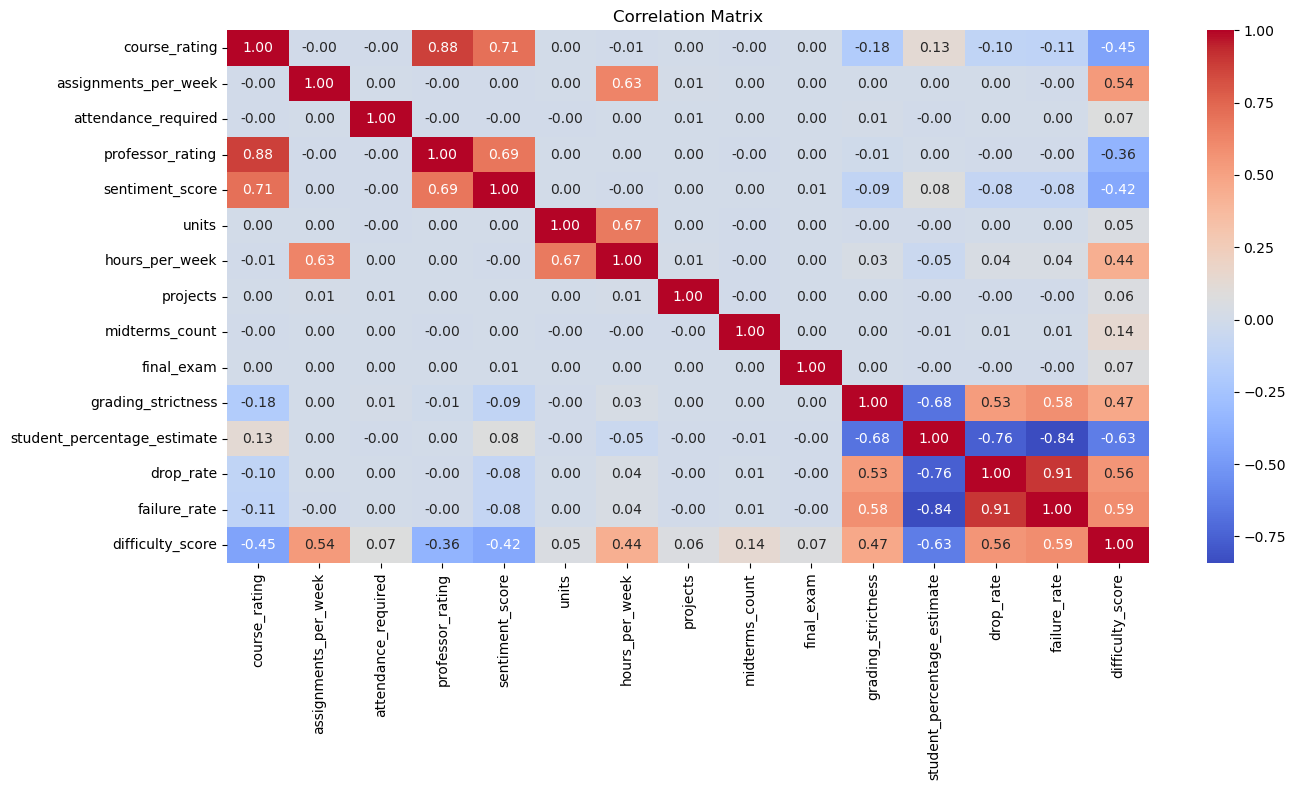

In [418]:
# visualizing the correlations between numeric features to identify patterns and potential data issues.
plt.figure(figsize=(14, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


We are plotting the distributions of key numeric features to visually inspect their spread, identify skewness in the dataset.

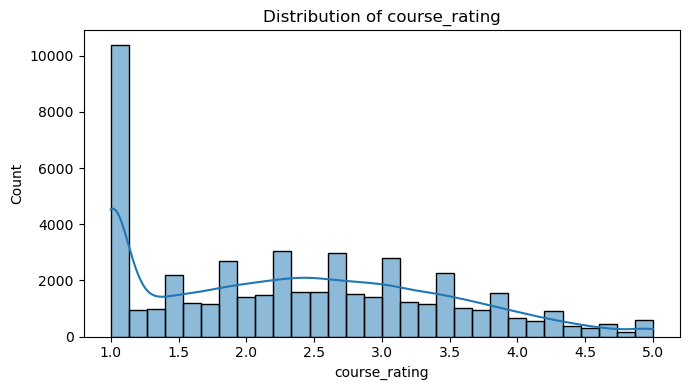

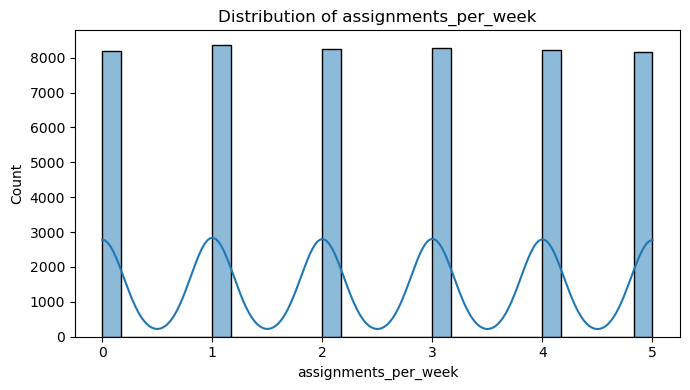

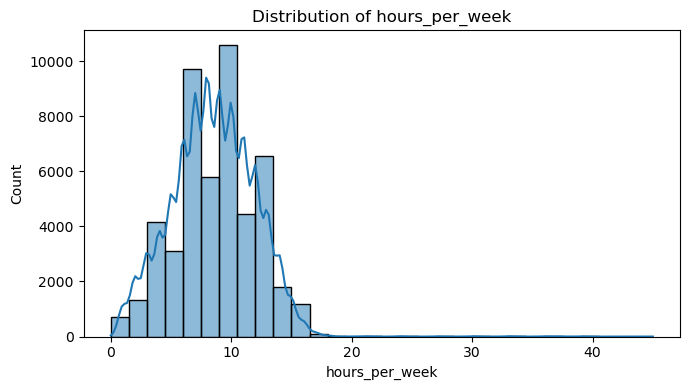

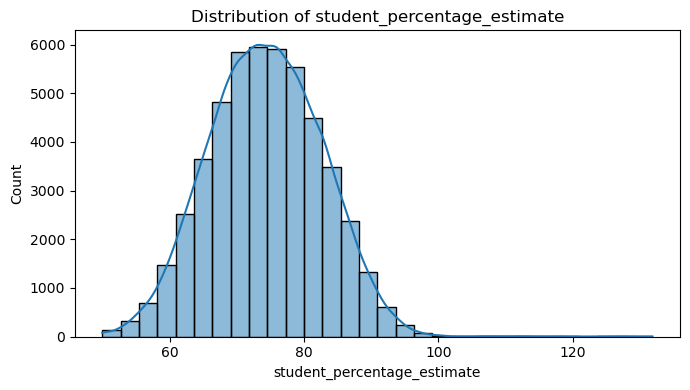

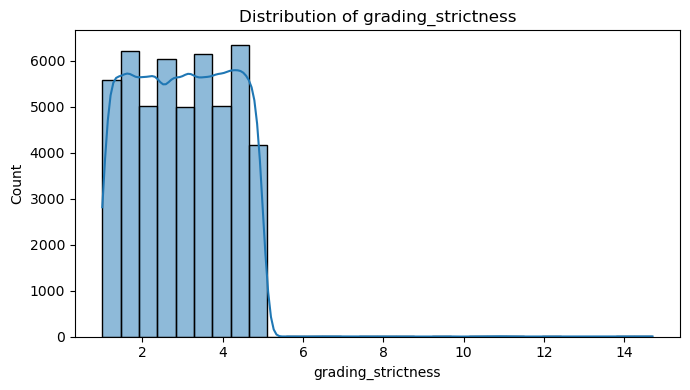

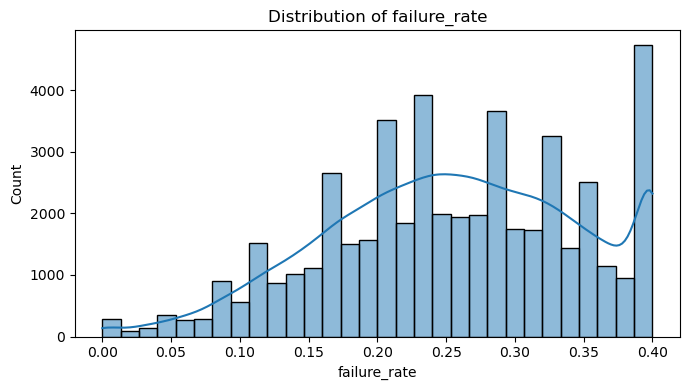

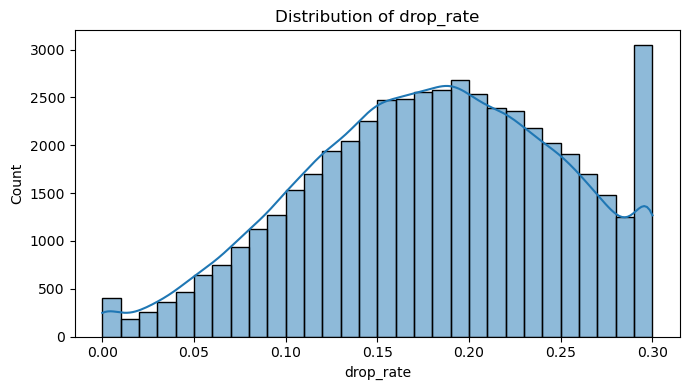

In [422]:
# List of key numeric features
numeric_cols = ['course_rating', 'assignments_per_week', 'hours_per_week',
                'student_percentage_estimate', 'grading_strictness',
                'failure_rate', 'drop_rate']

# Plot distributions
for col in numeric_cols:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()


We are using boxplots to detect outliers and understand the range and central tendency of each numeric feature in the dataset.

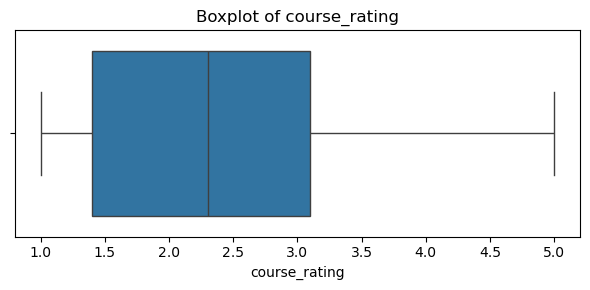

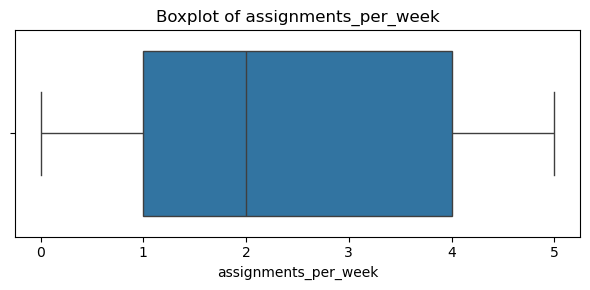

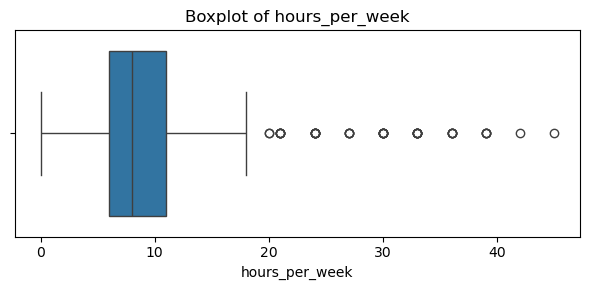

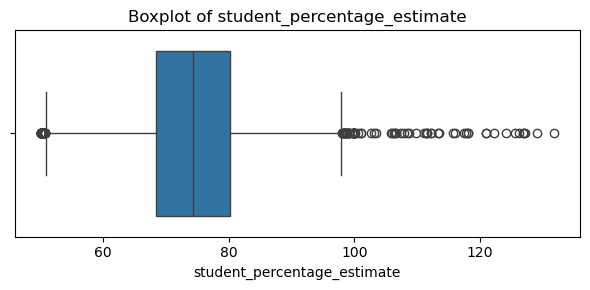

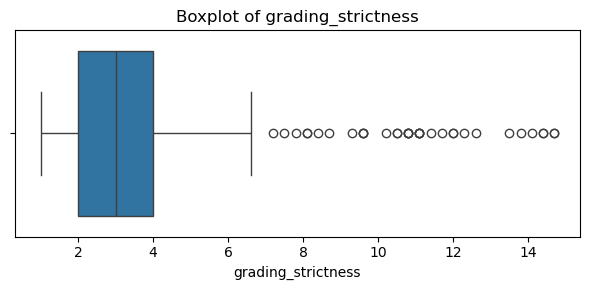

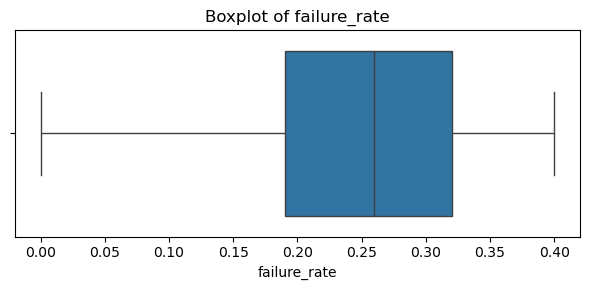

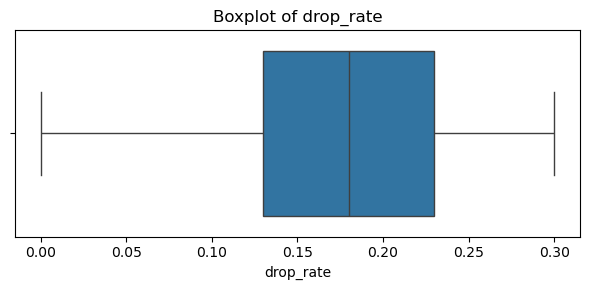

In [424]:
for col in numeric_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()


We are visualizing how each numeric feature varies across difficulty levels to explore potential patterns or differences between Easy, Medium, and Hard courses.

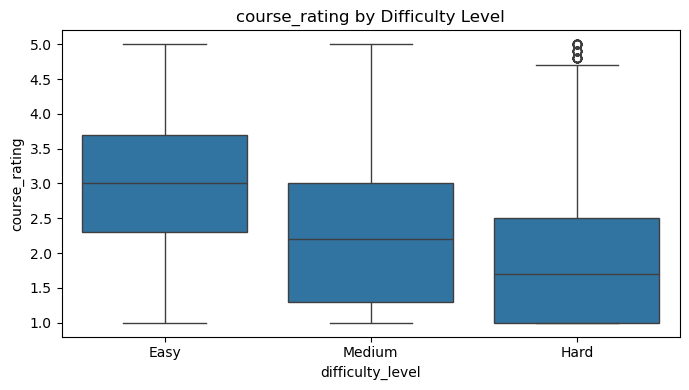

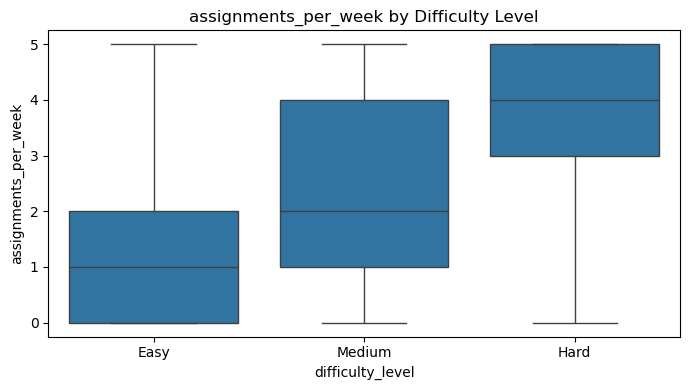

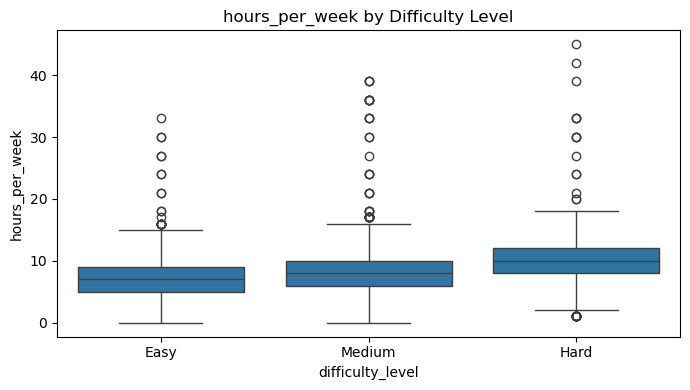

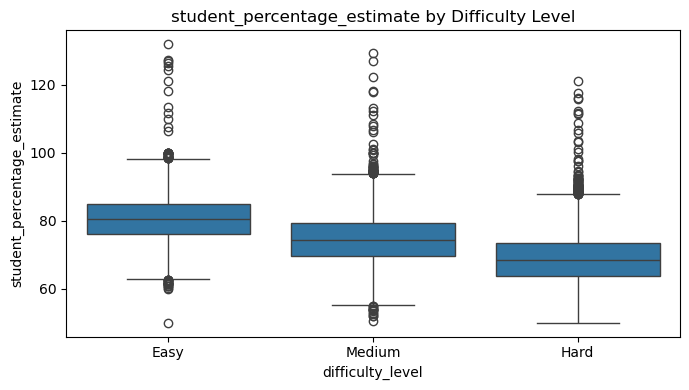

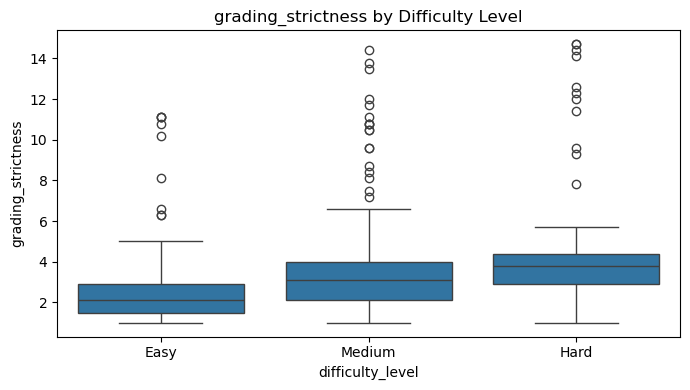

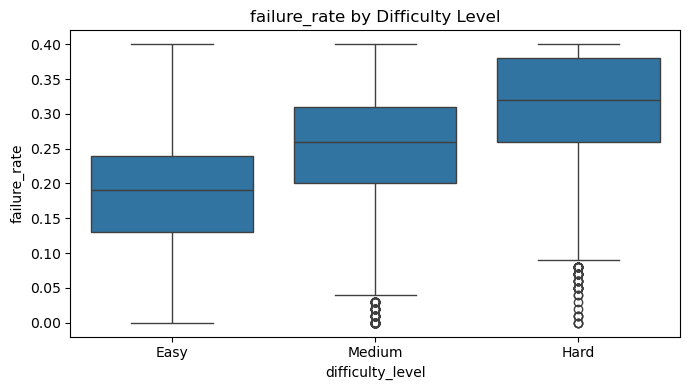

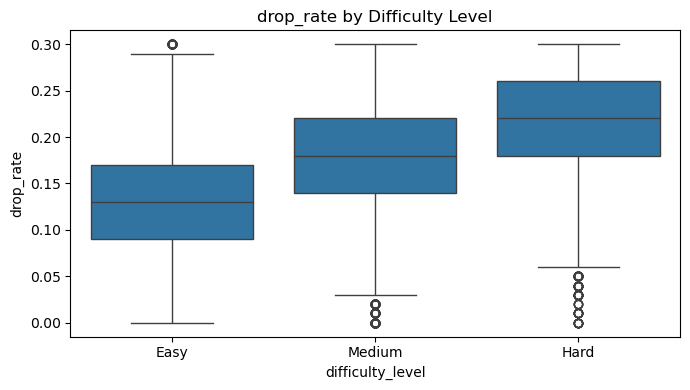

In [432]:
for col in numeric_cols:
    plt.figure(figsize=(7, 4))
    sns.boxplot(data=df, x='difficulty_level', y=col)
    plt.title(f"{col} by Difficulty Level")
    plt.tight_layout()
    plt.show()


We are plotting the frequency of each category in subject_area and difficulty_level to understand the class distribution and detect any imbalance in the dataset.

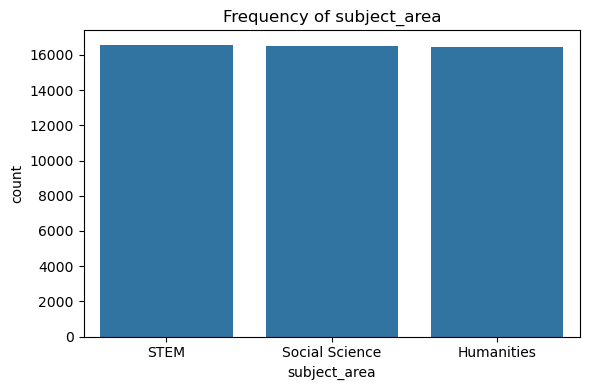

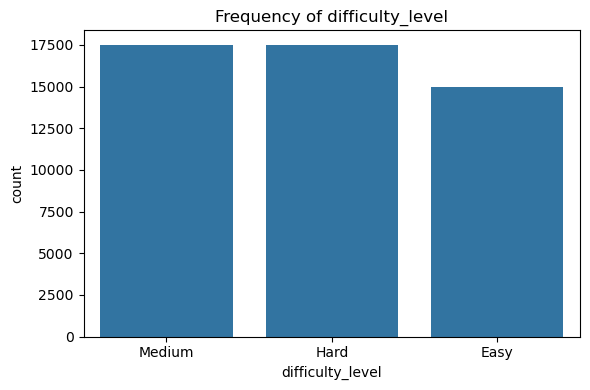

In [435]:
categorical_cols = ['subject_area', 'difficulty_level']
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Frequency of {col}")
    plt.tight_layout()
    plt.show()


We are generating a pairplot of numeric features, colored by difficulty level, to visualize relationships between variables and observe how Easy, Medium, and Hard courses cluster across different feature combinations.

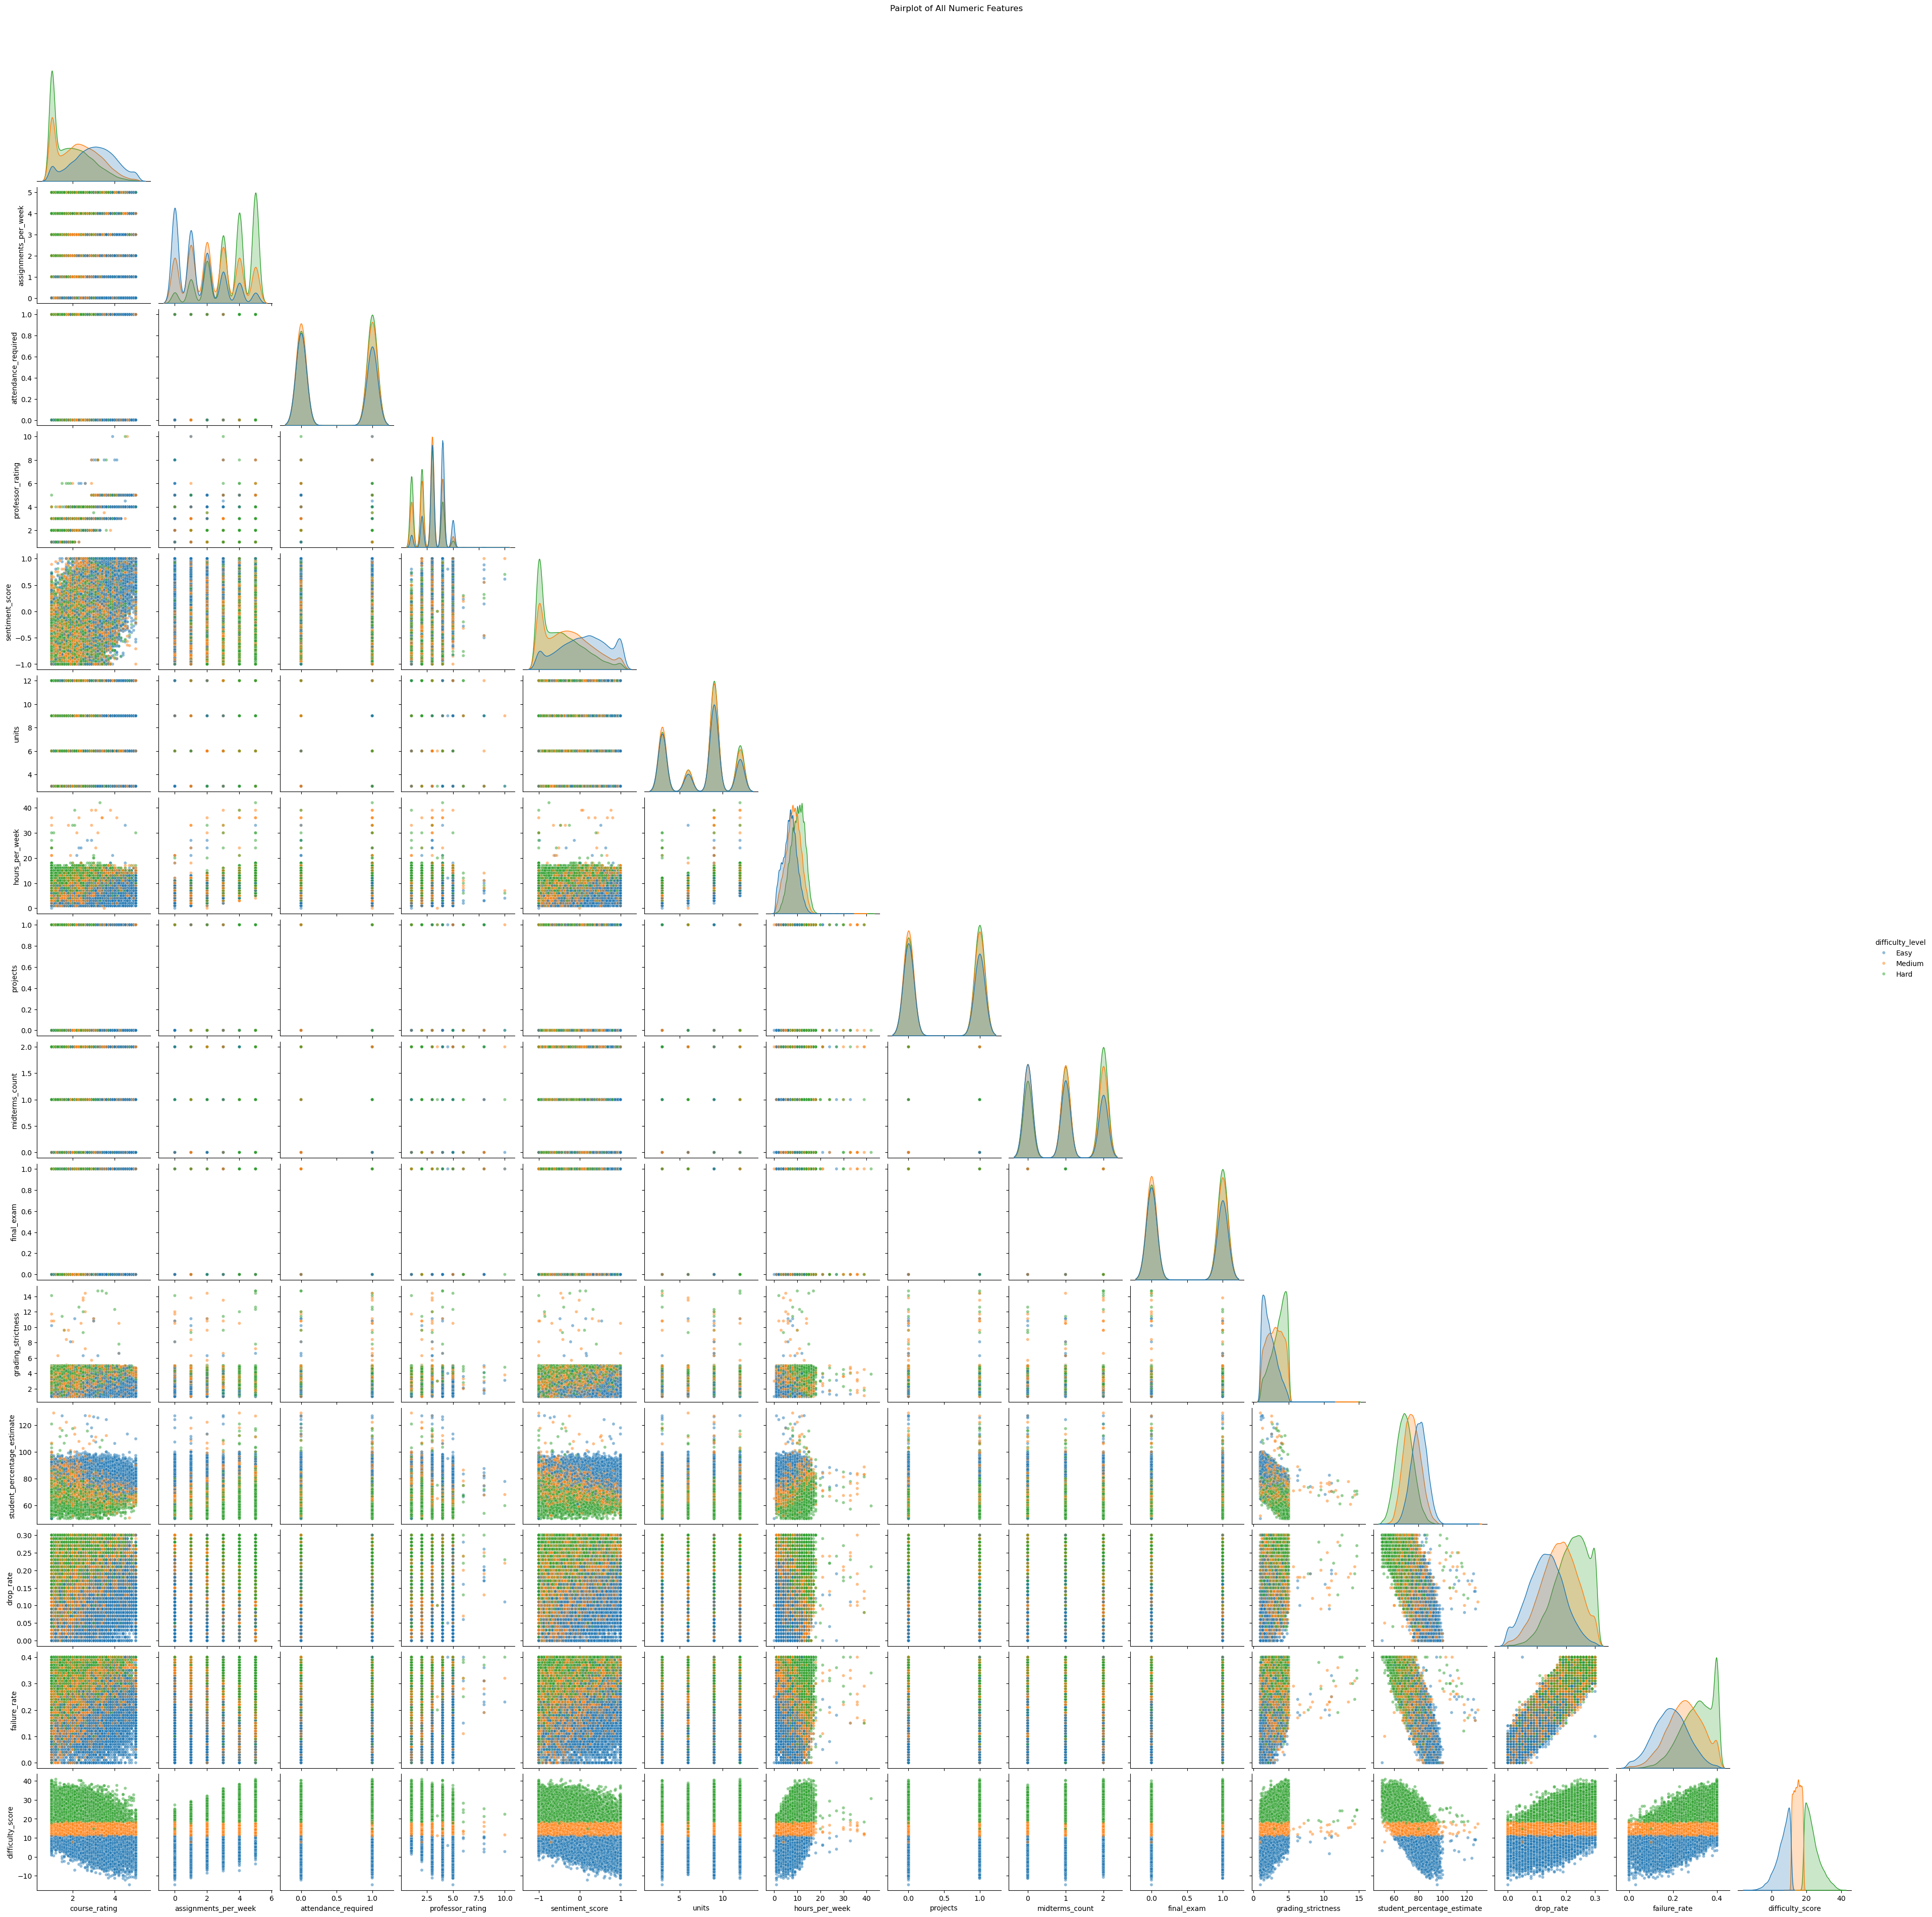

In [437]:
# Select only numeric columns and drop rows with missing values to avoid errors
numeric_df = df.select_dtypes(include='number').copy()
numeric_df['difficulty_level'] = df['difficulty_level']
numeric_df = numeric_df.dropna()

# Create pairplot
sns.pairplot(numeric_df, hue='difficulty_level', corner=True, plot_kws={'alpha': 0.5, 's': 20})
plt.suptitle("Pairplot of All Numeric Features", y=1.02)
plt.show()


# D2.3 Data Wrangling

In [441]:
# We are loading the dirty dataset and displaying its basic structure, summary statistics, and data types for initial exploration.
df = pd.read_csv('dirty_course_difficulty_dataset.csv')
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50010 entries, 0 to 50009
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   course_rating                49510 non-null  float64
 1   assignments_per_week         49510 non-null  float64
 2   attendance_required          49510 non-null  float64
 3   professor_rating             49510 non-null  float64
 4   sentiment_score              49510 non-null  float64
 5   subject_area                 49510 non-null  object 
 6   units                        49510 non-null  float64
 7   hours_per_week               49510 non-null  float64
 8   projects                     49510 non-null  float64
 9   midterms_count               49510 non-null  float64
 10  final_exam                   49510 non-null  float64
 11  grading_strictness           49510 non-null  float64
 12  student_percentage_estimate  49510 non-null  float64
 13  drop_rate       

course_rating  assignments_per_week  attendance_required  \
count   49510.000000          49510.000000         49510.000000   
mean        2.352583              2.494587             0.504201   
std         1.061929              1.704503             0.499987   
min         1.000000              0.000000             0.000000   
25%         1.400000              1.000000             0.000000   
50%         2.300000              2.000000             1.000000   
75%         3.100000              4.000000             1.000000   
max         5.000000              5.000000             1.000000   

       professor_rating  sentiment_score         units  hours_per_week  \
count      49510.000000     49510.000000  49510.000000    49510.000000   
mean           2.846728        -0.238962      7.638396        8.499131   
std            1.112241         0.608078      3.219988        3.362382   
min            1.000000        -1.000000      3.000000        0.000000   
25%            2.000000        -0.800000      3.000000        6.000000   
50%            3.000000        -0.300000      9.000000        8.000000   
75%            4.000000         0.210000      9.000000       11.000000   
max           10.000000         1.000000     12.000000       45.000000   

           projects  midterms_count    final_exam  grading_strictness  \
count  49510.000000    49510.000000  49510.000000        49510.000000   
mean       0.498647        1.001010      0.499111            3.005607   
std        0.500003        0.818127      0.500004            1.174929   
min        0.000000        0.000000      0.000000            1.000000   
25%        0.000000        0.000000      0.000000            2.000000   
50%        0.000000        1.000000      0.000000            3.000000   
75%        1.000000        2.000000      1.000000            4.000000   
max        1.000000        2.000000      1.000000           14.700000   

       student_percentage_estimate     drop_rate  failure_rate  \
count                 49510.000000  49510.000000  49510.000000   
mean                     74.306261      0.177794      0.254426   
std                       8.369150      0.069646      0.091501   
min                      50.000000      0.000000      0.000000   
25%                      68.400000      0.130000      0.190000   
50%                      74.300000      0.180000      0.260000   
75%                      80.200000      0.230000      0.320000   
max                     131.850000      0.300000      0.400000   

       difficulty_score  
count      50010.000000  
mean          15.328373  
std            7.892745  
min          -14.716594  
25%           10.029851  
50%           15.309765  
75%           20.625276  
max           41.640967

 We are adding duplicate rows ourselves to make more dirty (2%) 

In [443]:
df = pd.concat([df, df.sample(frac=0.02)])  # 2% duplicate rows

In [444]:
# Check for duplicate rows
duplicate_mask = df.duplicated()

# Count duplicate rows
num_duplicates = duplicate_mask.sum()

# Print the result
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 1000


In [445]:
# dropping any duplicate rows
df = df.drop_duplicates()

showing NO DUPLICATE ROWS

In [447]:
# Check for duplicate rows
duplicate_mask = df.duplicated()

# Count duplicate rows
num_duplicates = duplicate_mask.sum()

# Print the result
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


---------------------

We are imputing missing values by filling numeric columns with their mean and categorical columns with their most frequent value (mode) to restore dataset completeness for analysis.

In [450]:
# Option 1: Fill with mean (for numeric)
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Option 2: Fill with mode (for categoricals)
cat_cols = df.select_dtypes(include='object').columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

We are testing the normality of each numeric feature using the Shapiro-Wilk test, sampling up to 5,000 values per column, and classifying each as normally distributed or not based on a significance level of 0.05.

In [452]:
from scipy.stats import shapiro

# Get numeric columns (excluding any NaNs)
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Create the normality dictionary using Shapiro-Wilk test
is_normal_dict = {}
alpha = 0.05  # significance level

for col in numeric_cols:
    # Drop NaNs for the test
    data = df[col].dropna()

    # Shapiro-Wilk test: returns statistic and p-value
    stat, p_value = shapiro(data.sample(min(len(data), 5000)))  # use sample to speed up for large sets

    is_normal = p_value > alpha  # if p > 0.05, we consider the distribution normal
    is_normal_dict[col] = is_normal
    print(f"{col}: {'Normal' if is_normal else 'Not normal'} (p = {p_value:.4f})")

course_rating: Not normal (p = 0.0000)
assignments_per_week: Not normal (p = 0.0000)
attendance_required: Not normal (p = 0.0000)
professor_rating: Not normal (p = 0.0000)
sentiment_score: Not normal (p = 0.0000)
units: Not normal (p = 0.0000)
hours_per_week: Not normal (p = 0.0000)
projects: Not normal (p = 0.0000)
midterms_count: Not normal (p = 0.0000)
final_exam: Not normal (p = 0.0000)
grading_strictness: Not normal (p = 0.0000)
student_percentage_estimate: Not normal (p = 0.0002)
drop_rate: Not normal (p = 0.0000)
failure_rate: Not normal (p = 0.0000)
difficulty_score: Not normal (p = 0.0197)


--------------------------------

We are now defining a function to detect outliers in each numeric column by applying the Z-score method for normally distributed features and the IQR method for non-normal ones, then combining the results into a single mask to flag all outlier rows.

In [455]:
def detect_outliers(df, is_normal_dict):
    outlier_mask = pd.Series(False, index=df.index)

    for col in numeric_cols:
        data = df[col]

        if is_normal_dict[col]:
            # Z-score method for normal distribution
            mean_val = data.mean()
            std_val = data.std()
            z_scores = (data - mean_val) / std_val
            col_mask = abs(z_scores) > 2.5
        else:
            # IQR method for non-normal distribution
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            col_mask = (data < lower_bound) | (data > upper_bound)

        print(f"Column '{col}': {col_mask.sum()} outliers detected.")
        outlier_mask |= col_mask  # Combine this column’s mask with the overall

    return outlier_mask


We are applying the outlier detection function to flag and count outlier rows, then removing them to create a cleaned version of the dataset for further analysis.

In [458]:
# Apply the outlier detection
mask = detect_outliers(df, is_normal_dict)
print(f"\nTotal rows flagged as outliers: {mask.sum()}")

# Remove outliers
df_clean = df[~mask].reset_index(drop=True)
print(f"Cleaned dataset shape: {df_clean.shape}")

Column 'course_rating': 0 outliers detected.
Column 'assignments_per_week': 0 outliers detected.
Column 'attendance_required': 0 outliers detected.
Column 'professor_rating': 17 outliers detected.
Column 'sentiment_score': 0 outliers detected.
Column 'units': 0 outliers detected.
Column 'hours_per_week': 44 outliers detected.
Column 'projects': 0 outliers detected.
Column 'midterms_count': 0 outliers detected.
Column 'final_exam': 0 outliers detected.
Column 'grading_strictness': 35 outliers detected.
Column 'student_percentage_estimate': 152 outliers detected.
Column 'drop_rate': 0 outliers detected.
Column 'failure_rate': 0 outliers detected.
Column 'difficulty_score': 277 outliers detected.

Total rows flagged as outliers: 509
Cleaned dataset shape: (49501, 17)


# D2.4 Feature Engineering

## 1. Feature Importance: Correlation with Target

We are preparing the dataset for modeling by mapping difficulty levels to numeric values and applying one-hot encoding to convert the categorical subject_area feature into numerical format.

In [462]:
# Map labels to numeric for correlation
df_fe = df.copy()
df_fe['difficulty_level_num'] = df_fe['difficulty_level'].map({'Easy': 0, 'Medium': 1, 'Hard': 2})
df_fe = df_fe.drop('difficulty_level', axis=1)

# One-Hot Encoding to cast subject area variable to a numerical value
df_fe = pd.get_dummies(df_fe, columns=['subject_area'])

We are calculating the absolute correlation of each feature with the target variable `difficulty_level_num`, sorting them to identify the most influential predictors, and visualizing the results with a barplot for easier interpretation.

Correlation with difficulty_level:
difficulty_score               0.892404
student_percentage_estimate    0.560653
failure_rate                   0.535506
drop_rate                      0.503172
assignments_per_week           0.496870
grading_strictness             0.434216
course_rating                  0.408894
hours_per_week                 0.399689
sentiment_score                0.377200
subject_area_STEM              0.345814
professor_rating               0.327222
subject_area_Humanities        0.218414
subject_area_Social Science    0.130483
midterms_count                 0.123317
attendance_required            0.065347
final_exam                     0.061050
projects                       0.050941
units                          0.046032
Name: difficulty_level_num, dtype: float64


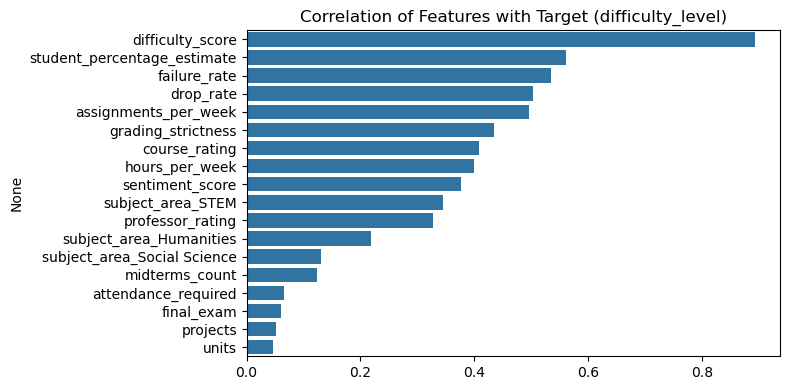

course_rating  assignments_per_week  attendance_required  \
0                2.8                   1.0                  1.0   
1                3.1                   0.0                  1.0   
2                3.9                   2.0                  0.0   
3                1.8                   5.0                  0.0   
4                3.3                   3.0                  0.0   
...              ...                   ...                  ...   
50005            5.0                   3.0                  1.0   
50006            2.0                   1.0                  0.0   
50007            3.0                   0.0                  1.0   
50008            1.0                   1.0                  1.0   
50009            3.0                   2.0                  1.0   

       professor_rating  sentiment_score  units  hours_per_week  projects  \
0                   4.0             0.18   12.0        9.000000       1.0   
1                   3.0             0.40    3.0        2.000000       0.0   
2                   4.0             0.59    3.0        8.499131       1.0   
3                   2.0            -0.57    9.0       13.000000       1.0   
4                   4.0             1.00    9.0       11.000000       0.0   
...                 ...              ...    ...             ...       ...   
50005               5.0            -1.00   12.0       15.000000       1.0   
50006               3.0            -0.30    3.0        5.000000       0.0   
50007               4.0             0.20    6.0       20.000000       1.0   
50008               5.0            -0.50    6.0        8.000000       0.0   
50009               3.5             0.00    3.0       20.000000       1.0   

       midterms_count  final_exam  grading_strictness  \
0                 0.0         0.0                 1.0   
1                 1.0         0.0                 3.3   
2                 2.0         1.0                 2.4   
3                 1.0         1.0                 1.0   
4                 0.0         0.0                 4.0   
...               ...         ...                 ...   
50005             2.0         1.0                 3.5   
50006             0.0         1.0                 5.0   
50007             1.0         1.0                 3.0   
50008             1.0         1.0                 4.0   
50009             1.0         1.0                 3.0   

       student_percentage_estimate  drop_rate  failure_rate  difficulty_score  \
0                             89.9       0.10      0.080000         -2.252490   
1                             65.5       0.28      0.340000         13.940905   
2                             73.8       0.16      0.280000         10.155458   
3                             91.2       0.00      0.000000         15.505456   
4                             64.7       0.24      0.254426         15.787459   
...                            ...        ...           ...               ...   
50005                         90.0       0.05      0.050000         13.141790   
50006                         60.0       0.10      0.300000         13.213071   
50007                         80.0       0.05      0.100000         14.738283   
50008                         70.0       0.20      0.200000         17.734865   
50009                         75.0       0.10      0.200000         21.579648   

       difficulty_level_num  subject_area_Humanities  subject_area_STEM  \
0                         0                     True              False   
1                         1                    False               True   
2                         0                     True              False   
3                         1                     True              False   
4                         1                    False              False   
...                     ...                      ...                ...   
50005                     1                    False               True   
50006              

In [465]:
# Correlation with target
corrs = df_fe.corr(numeric_only=True)['difficulty_level_num'].drop('difficulty_level_num')
corrs = corrs.abs().sort_values(ascending=False)
print("Correlation with difficulty_level:")
print(corrs)

# Plot top correlations
plt.figure(figsize=(8, 4))
sns.barplot(x=corrs.values, y=corrs.index)
plt.title("Correlation of Features with Target (difficulty_level)")
plt.tight_layout()
plt.show()
df_fe

## 2. Prune Redundant Features 

We are visualizing the full correlation matrix of the feature-engineered dataset to examine relationships between all numeric variables, including the encoded target and one-hot encoded subject areas.










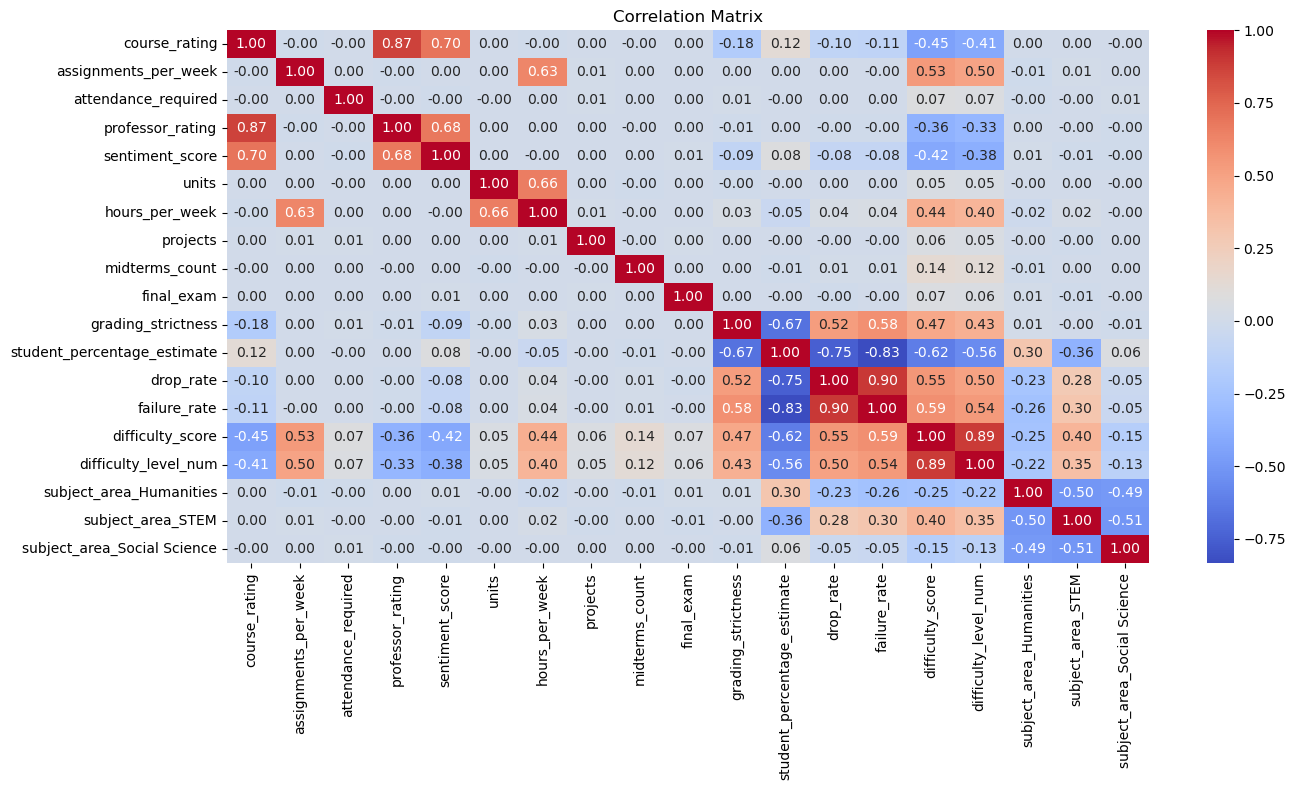

In [468]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_fe.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

----------------

We are removing highly correlated and redundant features to reduce multicollinearity and simplify the dataset, keeping only the most informative predictors for modeling.

In [471]:
# Drop if highly correlated (>0.8) or duplicates
df_fe = df_fe.drop(columns=[
    'drop_rate',          # due to 0.90 corr with failure_rate
    'student_percentage_estimate', # due to -0.81 corr with failiure_rate
    'professor_rating',    # due to 0.87 corr with course_rating
    'difficulty_score'    # due to 0.89 corr with difficulty_level_num
    
])

-------------

We are re-plotting the correlation matrix after dropping highly correlated features to confirm reduced multicollinearity and ensure the remaining variables are more independent for modeling.

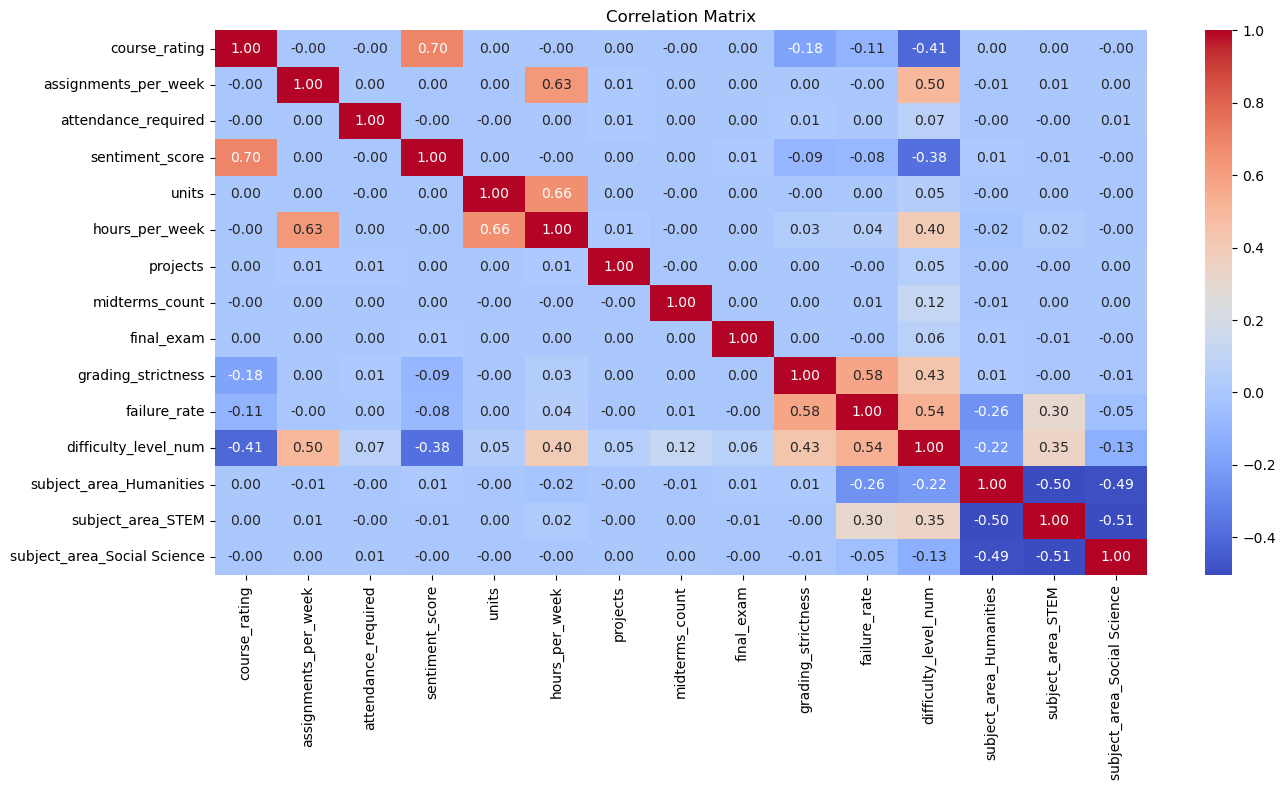

In [475]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_fe.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

##  3. Feature Creation

We are engineering two new features: perceived_difficulty, which captures how hard a course feels based on course rating and sentiment, and effort_score, which quantifies the actual workload by combining hours, assignments, and units into a single metric.

In [479]:
# Combine hours, assignments, and units into a single 'effort' metric
df_fe['effort_score'] = (
    df_fe['hours_per_week'] * 0.4 +
    df_fe['assignments_per_week'] * 2 +
    df_fe['units'] * 0.5
)


In [480]:
# Weighted composite from sentiment and course rating
df_fe['perceived_difficulty'] = (
    5 - df_fe['course_rating'] + (1 - df_fe['sentiment_score']) * 2
)


## 4. Feature Scaling

We are scaling all numeric features (excluding the target variable) using standard scaler to ensure they are on the same scale, which is essential for many machine learning algorithms to perform effectively.

In [483]:
from sklearn.preprocessing import StandardScaler

# Automatically detect numeric columns excluding labels
numeric_df = df_fe.select_dtypes(include='number')
exclude_cols = ['difficulty_level_num']  # keep only target out
scale_df = numeric_df.drop(columns=exclude_cols)

# Fit and transform
scaler = StandardScaler()
scaled_array = scaler.fit_transform(scale_df)

# Update df_fe with scaled values
df_fe[scale_df.columns] = scaled_array

print("All numeric features scaled (excluding target).")



All numeric features scaled (excluding target).


# Targeted Final Exploratory Data Analysis

We are reviewing the final dataset's structure, types, and statistics to confirm it's clean and ready for modeling.

In [486]:
df_fe.head()
df_fe.info()
df_fe.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 50010 entries, 0 to 50009
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   course_rating                50010 non-null  float64
 1   assignments_per_week         50010 non-null  float64
 2   attendance_required          50010 non-null  float64
 3   sentiment_score              50010 non-null  float64
 4   units                        50010 non-null  float64
 5   hours_per_week               50010 non-null  float64
 6   projects                     50010 non-null  float64
 7   midterms_count               50010 non-null  float64
 8   final_exam                   50010 non-null  float64
 9   grading_strictness           50010 non-null  float64
 10  failure_rate                 50010 non-null  float64
 11  difficulty_level_num         50010 non-null  int64  
 12  subject_area_Humanities      50010 non-null  bool   
 13  subject_area_STEM    

course_rating  assignments_per_week  attendance_required  \
count   5.001000e+04          5.001000e+04         5.001000e+04   
mean    3.438339e-16          6.109446e-17        -3.196803e-17   
std     1.000010e+00          1.000010e+00         1.000010e+00   
min    -1.280132e+00         -1.470914e+00        -1.013517e+00   
25%    -9.015582e-01         -8.812715e-01        -1.013517e+00   
50%    -4.976669e-02          0.000000e+00         0.000000e+00   
75%     7.073813e-01          8.876550e-01         9.966273e-01   
max     2.505608e+00          1.477297e+00         9.966273e-01   

       sentiment_score         units  hours_per_week      projects  \
count     5.001000e+04  5.001000e+04    5.001000e+04  5.001000e+04   
mean     -7.104007e-20 -2.690998e-16   -5.037451e-16  1.291508e-16   
std       1.000010e+00  1.000010e+00    1.000010e+00  1.000010e+00   
min      -1.257863e+00 -1.447771e+00   -2.540469e+00 -1.002320e+00   
25%      -9.272980e-01 -1.447771e+00   -7.470135e-01 -1.002320e+00   
50%      -8.435688e-02  4.249941e-01   -5.309695e-16  0.000000e+00   
75%       7.420560e-01  4.249941e-01    7.475327e-01  1.007761e+00   
max       2.047788e+00  1.361377e+00    1.091045e+01  1.007761e+00   

       midterms_count    final_exam  grading_strictness  failure_rate  \
count    5.001000e+04  5.001000e+04        5.001000e+04  5.001000e+04   
mean    -1.013031e-16 -1.423643e-16       -2.945321e-16 -1.402331e-16   
std      1.000010e+00  1.000010e+00        1.000010e+00  1.000010e+00   
min     -1.229714e+00 -1.003252e+00       -1.715618e+00 -2.794610e+00   
25%     -1.229714e+00 -1.003252e+00       -8.602073e-01 -7.076502e-01   
50%     -1.240631e-03  0.000000e+00       -4.796245e-03  6.122951e-02   
75%      1.227232e+00  1.006825e+00        8.506148e-01  7.202693e-01   
max      1.227232e+00  1.006825e+00        1.000351e+01  1.598989e+00   

       difficulty_level_num  effort_score  perceived_difficulty  
count          50010.000000  5.001000e+04          5.001000e+04  
mean               1.049990  2.774115e-16          1.962127e-16  
std                0.804676  1.000010e+00          1.000010e+00  
min                0.000000 -2.168008e+00         -2.452636e+00  
25%                0.000000 -6.697616e-01         -7.299232e-01  
50%                1.000000 -2.187129e-02          7.400929e-02  
75%                2.000000  7.879916e-01          8.683711e-01  
max                2.000000  4.412128e+00          1.375614e+00

We are checking how strongly the new features effort_score and perceived_difficulty correlate with the target variable to evaluate their relevance for prediction.

In [488]:
# 1. Check correlation with target
new_features = ['effort_score', 'perceived_difficulty']
for feature in new_features:
    corr = df_fe[feature].corr(df_fe['difficulty_level_num'])
    print(f"Correlation of {feature} with difficulty_level_num: {corr:.3f}")


Correlation of effort_score with difficulty_level_num: 0.464
Correlation of perceived_difficulty with difficulty_level_num: 0.425


We are plotting the final correlation matrix to visualize relationships among all numeric features, including newly engineered ones, and assess their alignment with the target variable.

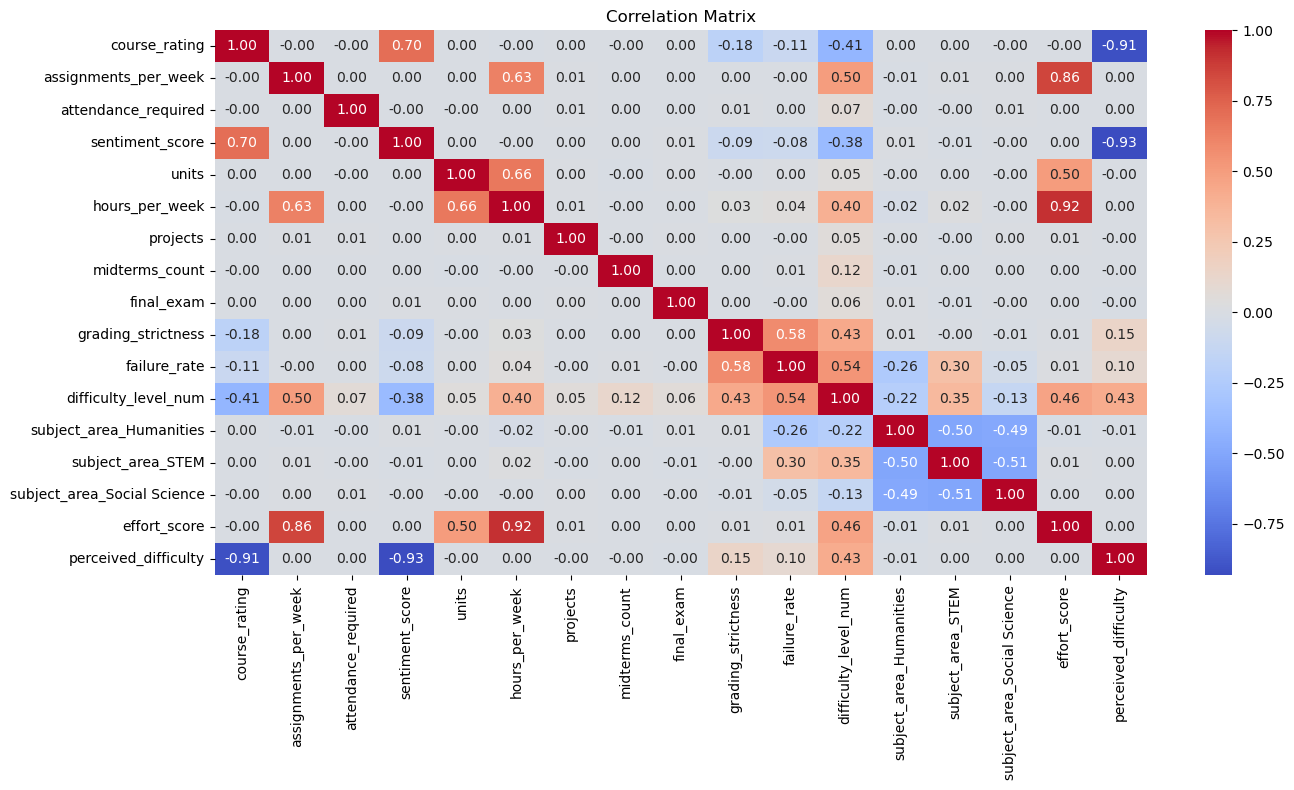

In [490]:
plt.figure(figsize=(14, 8))
sns.heatmap(df_fe.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()


------------

We are printing a sorted list of feature correlations with the target `difficulty_level_num` to identify which variables are most positively or negatively associated with course difficulty.

In [493]:
corrs = df_fe.corr()['difficulty_level_num'].sort_values(ascending=False)
print(corrs)

difficulty_level_num           1.000000
failure_rate                   0.535506
assignments_per_week           0.496870
effort_score                   0.464442
grading_strictness             0.434216
perceived_difficulty           0.425159
hours_per_week                 0.399689
subject_area_STEM              0.345814
midterms_count                 0.123317
attendance_required            0.065347
final_exam                     0.061050
projects                       0.050941
units                          0.046032
subject_area_Social Science   -0.130483
subject_area_Humanities       -0.218414
sentiment_score               -0.377200
course_rating                 -0.408894
Name: difficulty_level_num, dtype: float64


------------

We are using boxplots to visualize how each numeric feature varies across difficulty levels, helping us spot trends, differences, and potential predictors for course difficulty classification.

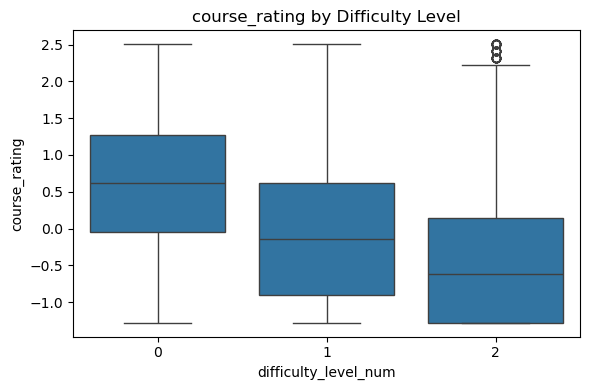

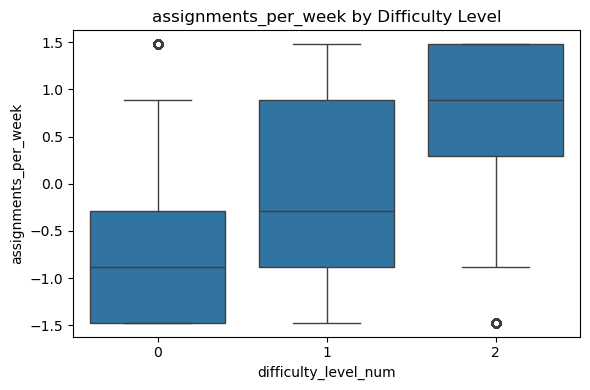

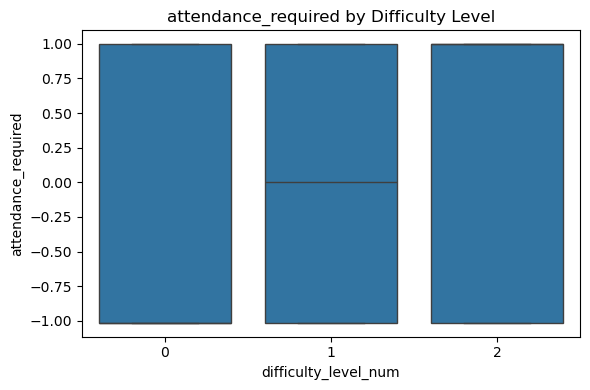

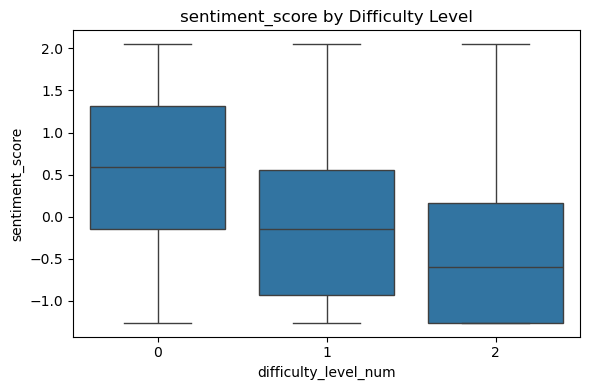

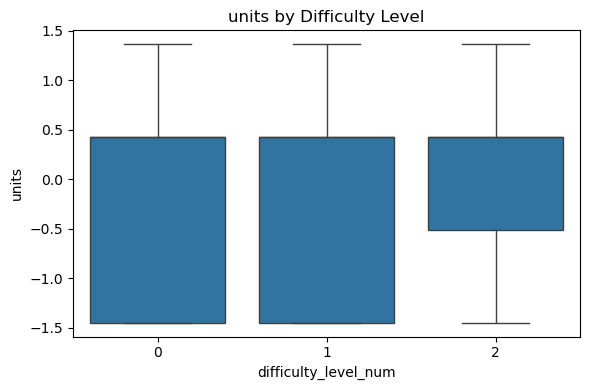

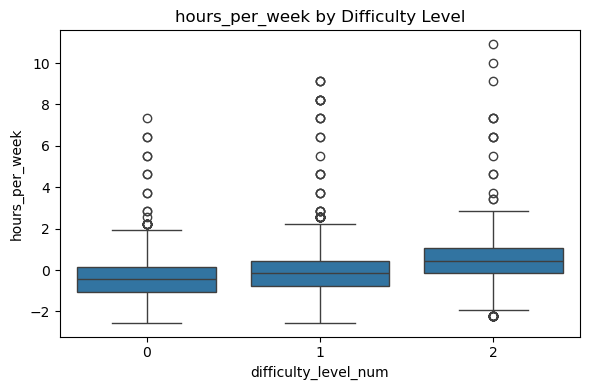

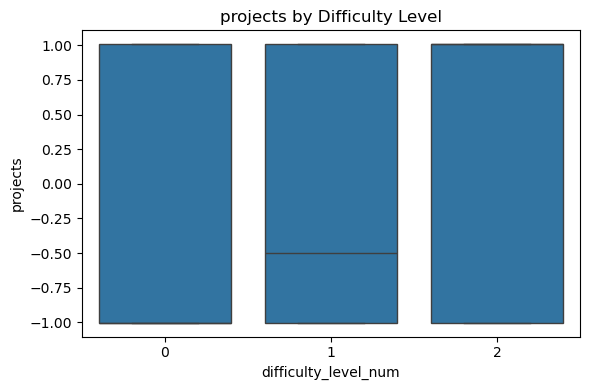

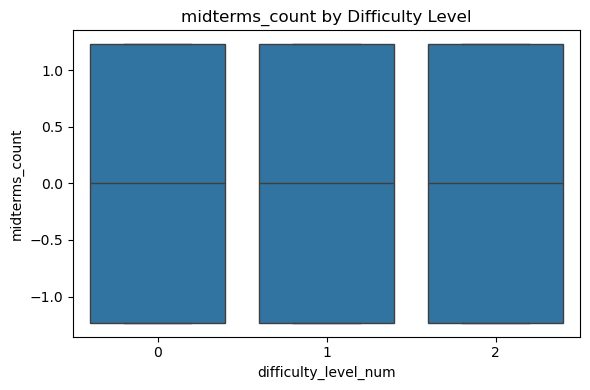

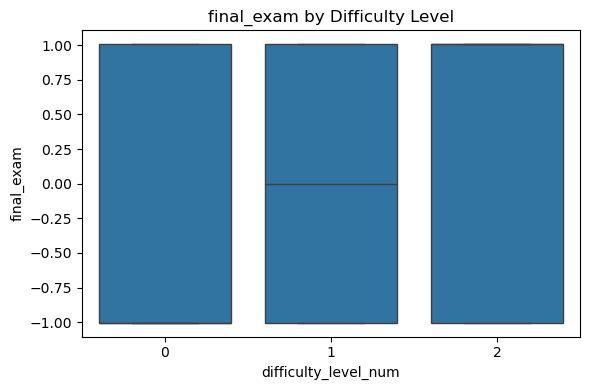

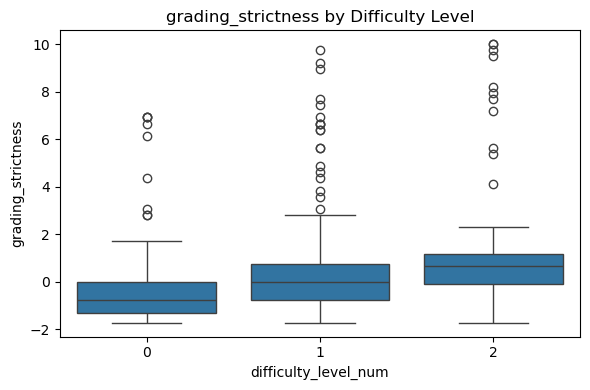

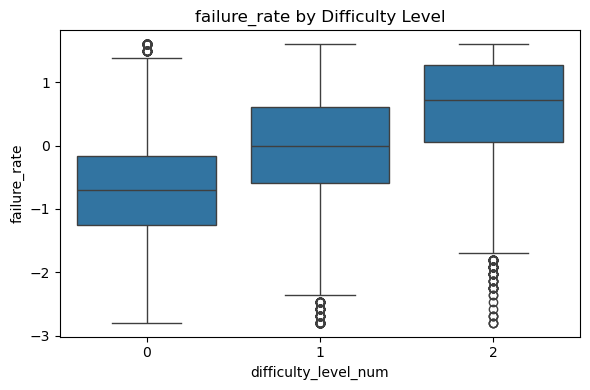

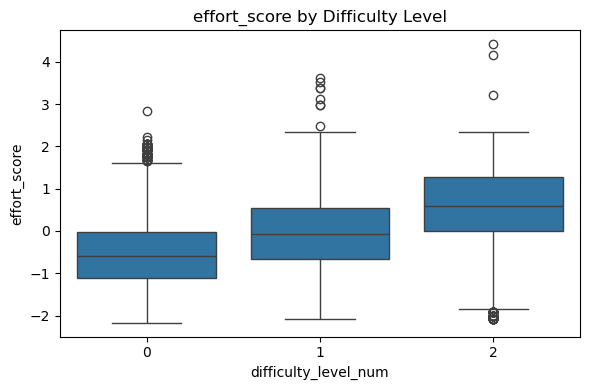

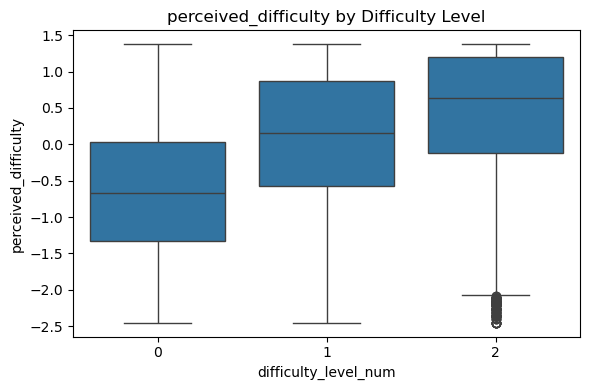

In [496]:
for col in df_fe.select_dtypes(include='number').columns:
    if col != 'difficulty_level_num':
        plt.figure(figsize=(6, 4))
        sns.boxplot(data=df_fe, x='difficulty_level_num', y=col)
        plt.title(f"{col} by Difficulty Level")
        plt.tight_layout()
        plt.show()


-----------

We are plotting the distribution of each numeric feature to examine their shape, spread, and skewness, which helps in understanding data behavior and detecting anomalies before modeling.

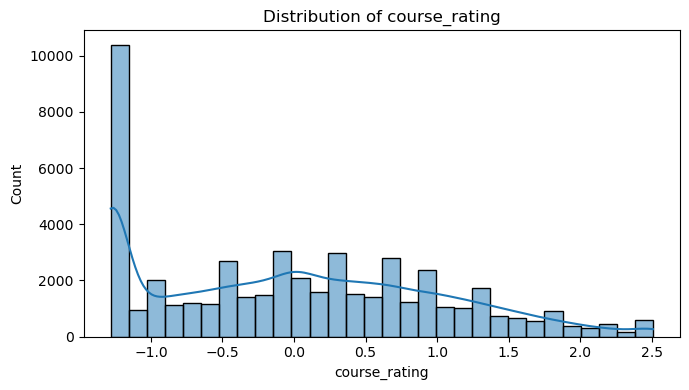

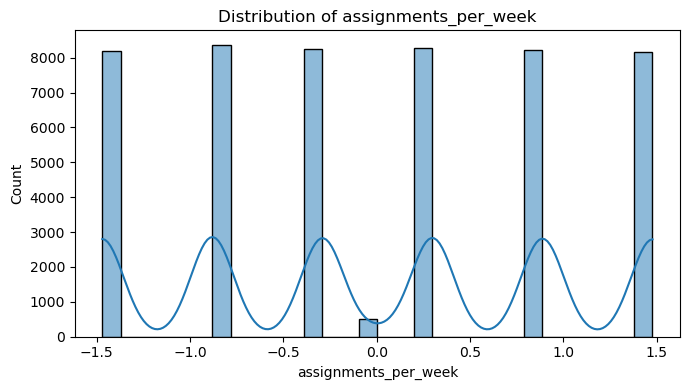

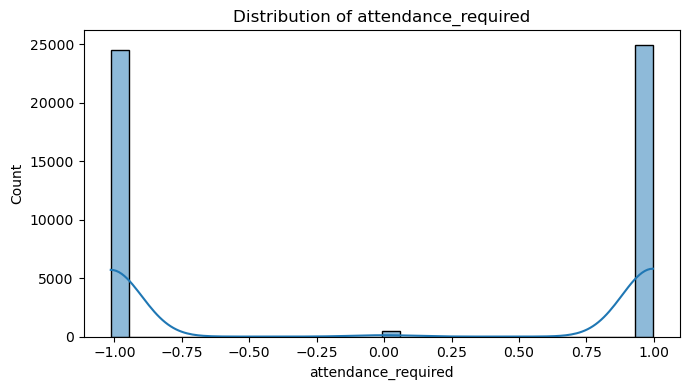

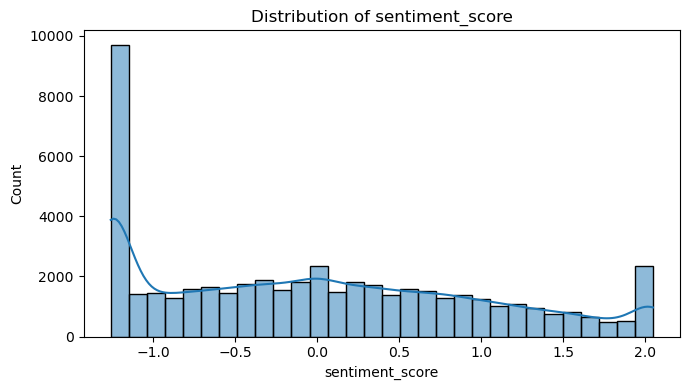

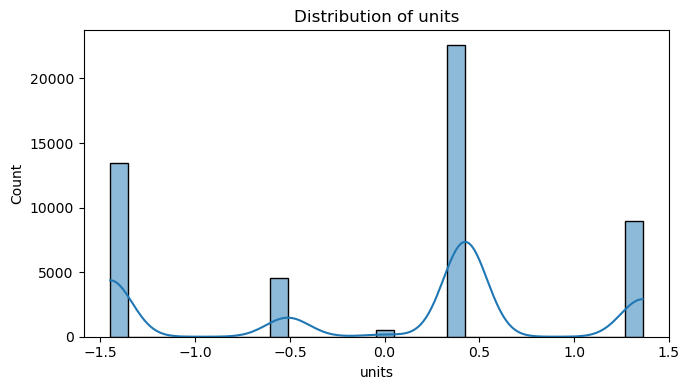

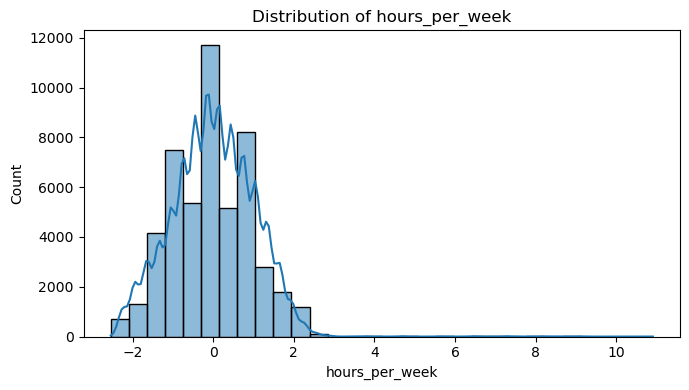

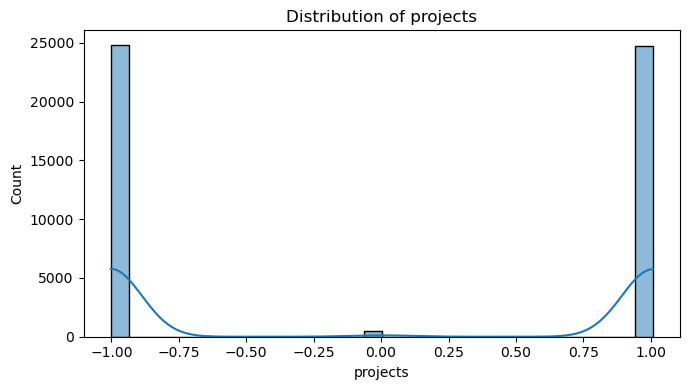

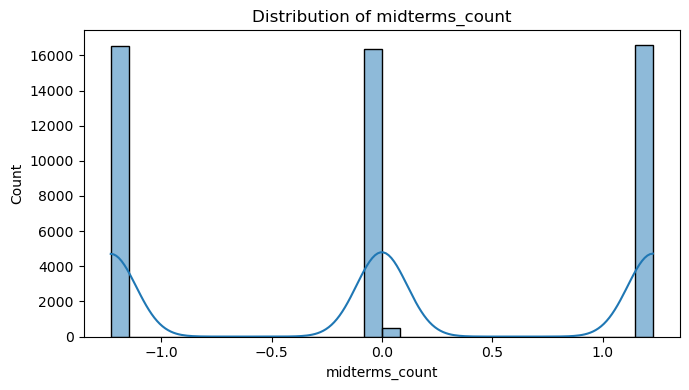

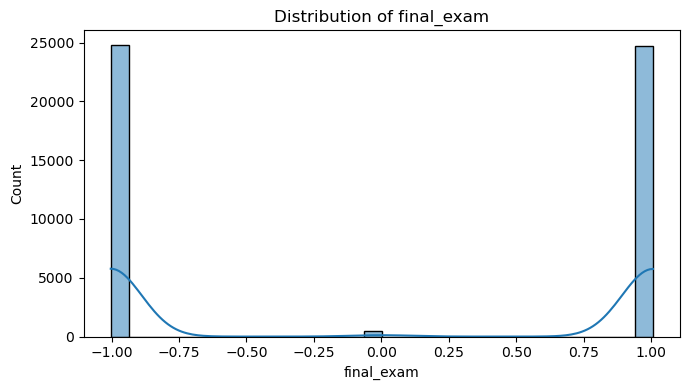

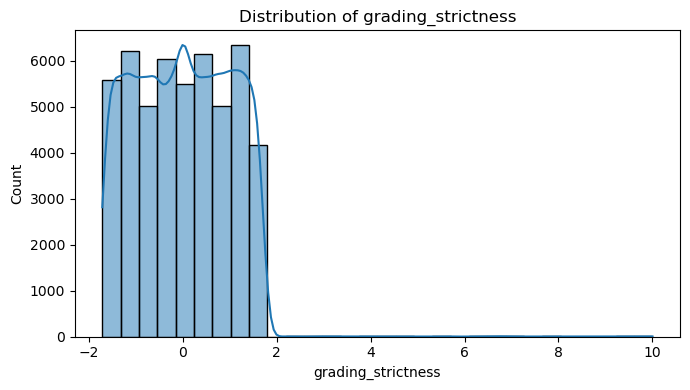

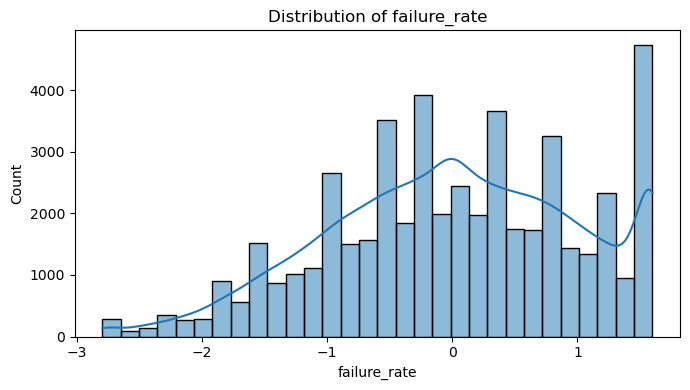

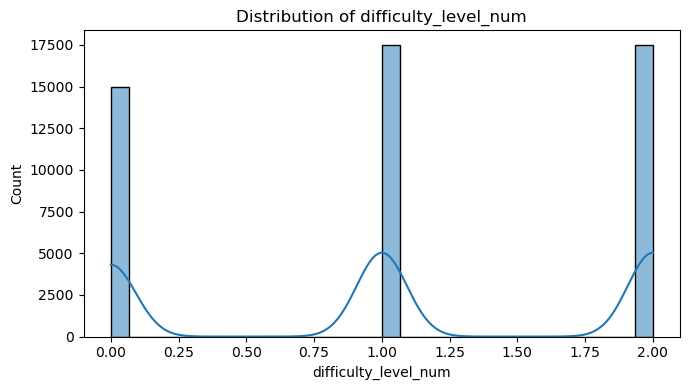

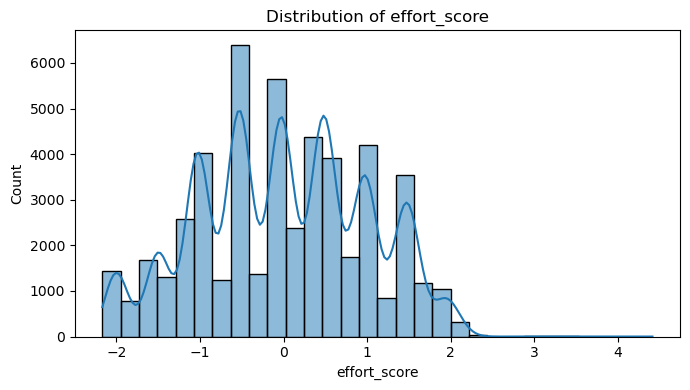

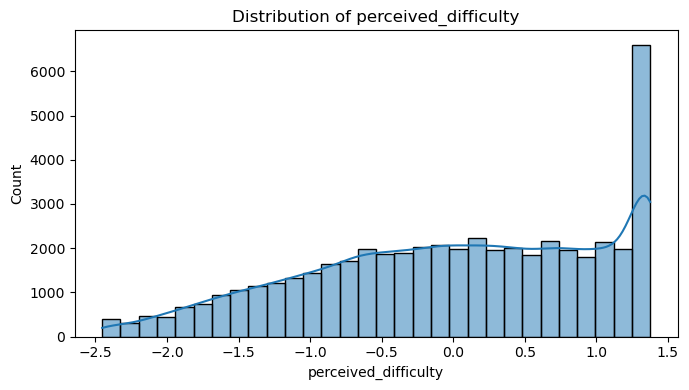

In [499]:
for col in df_fe.select_dtypes(include='number').columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(df_fe[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

Save final cleaned and feature-engineered dataset

In [501]:
df_fe.to_csv("cleaned_course_difficulty_dataset.csv", index=False)
print("Final dataset saved as 'cleaned_course_difficulty_dataset.csv'")


Final dataset saved as 'cleaned_course_difficulty_dataset.csv'


# Final Summary

This section of the project focused on generating and preparing a synthetic dataset to explore course difficulty. We simulated realistic university course data by designing features with logical dependencies (for example hours vs units or grading vs failure rates), and injected noise, missing values, and outliers to reflect real-world data imperfections.

Throughout the process, we conducted data analysis at each stage - including correlation checks, distribution plots, and class balance reviews - to ensure that our transformations preserved meaningful patterns and introduced variability responsibly.

Key steps included:
- Injecting logical and extreme anomalies into selected features
- Cleaning missing and inconsistent values
- Detecting and removing outliers using Z-score and IQR methods
- Engineering new features like `underperformance_risk` and `effort_score`
- Dropping features with high correlation (>|0.8|) to reduce redundancy
- Scaling numerical columns for modeling readiness

The resulting dataset is now structured, interpretable, and ready for training.
